# Анализ данных с временой структурой
# Проект 2

#### Участники:<br>
**Ванифатов Кирилл**<br>
**Молоков Андрей**

Задача:
Построить автоматизированный пайплайн для прогнозирования значений временного ряда

Требования:
- Выбор оптимизируемой метрики должен быть основан на потребностях бизнеса
- Модель может использовать внешние факторы (см подсказки)

- Модель должна иметь модуль отбора признаков
- Метод отбора должен быть болеее стабильным относительно альтернатив
- Сравнение должно быть проведено минимум с одним методом из каждой категории: встроенные, оберточные и фильтрационные
- При этом как минимум одна из альтернатив должа исследовать нелинейную зависимость

- Модель должна автоматически подбирать гиперпараметры, оптимизируя целевую метрику

- Для модели должна быть подобрана частота калибровки, если модель калибруется долго, и проверена ее достаточность

- Блоки должны быть подписаны и кратко описаны (чем руководствовались при реализации, как работает)
- Модель должна автоматически дообучаться
- Все модули должны работать без ручных корректировок
- Выбор периода для дообучения должен быть обоснован

- В модели должен быть модуль выявления разладки для подачи сигнала о возможной необходимости переключения на ручное управление процессом/внеплановое дообучение

Подсказки:
- Можно использовать факторы, сконструированные из таргета (лаги, средние и т.п.)
- Могут помочь макроэкономические факторы
- Могут помочь даты налоговых дней

Описание бизнес-процесса:
- Прогнозная величина позволяет установить сальдо поступлений и списаний за день
- На основании прогноза позиционер (управляет ликвидностью) принимает решение о выделении средств на размещение на рынке деривативов для получения дополнительной маржи (доходность считать примерно ключ+0.5%)
- В случае, если на конец дня образуется профицит ликвидности, его можно разместить в ЦБ по overnight ставке, равной ключу-0.9%
- В случае, если на конец дня образуется дефицит ликвидности, его можно покрыть за счет займа по overnight ставке, равной ключ+1%

In [8]:
# !pip3 install statsmodels
# !pip3 install seaborn
# !pip3 install scikit-learn
# !pip3 install arch

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

import scipy.stats as scs
import statsmodels.api as sm

# import statsmodels as smt

In [27]:
data_origin = pd.read_excel('Project_Data.xlsx')
data_origin.shape

(1543, 4)

In [28]:
data_origin['Date'] = pd.to_datetime(data_origin['Date']).dt.date
data_origin = data_origin.set_index('Date')
data_origin = data_origin.asfreq('D')
data_origin.head()

,Income,Outcome,Balance
Date,,,
2017-01-09,1.343028,1.487865,-0.155904
2017-01-10,1.068610,1.194182,-0.125572
2017-01-11,0.944429,0.936663,0.007767
2017-01-12,1.672202,0.875379,0.800391
2017-01-13,0.955924,0.975645,-0.019721


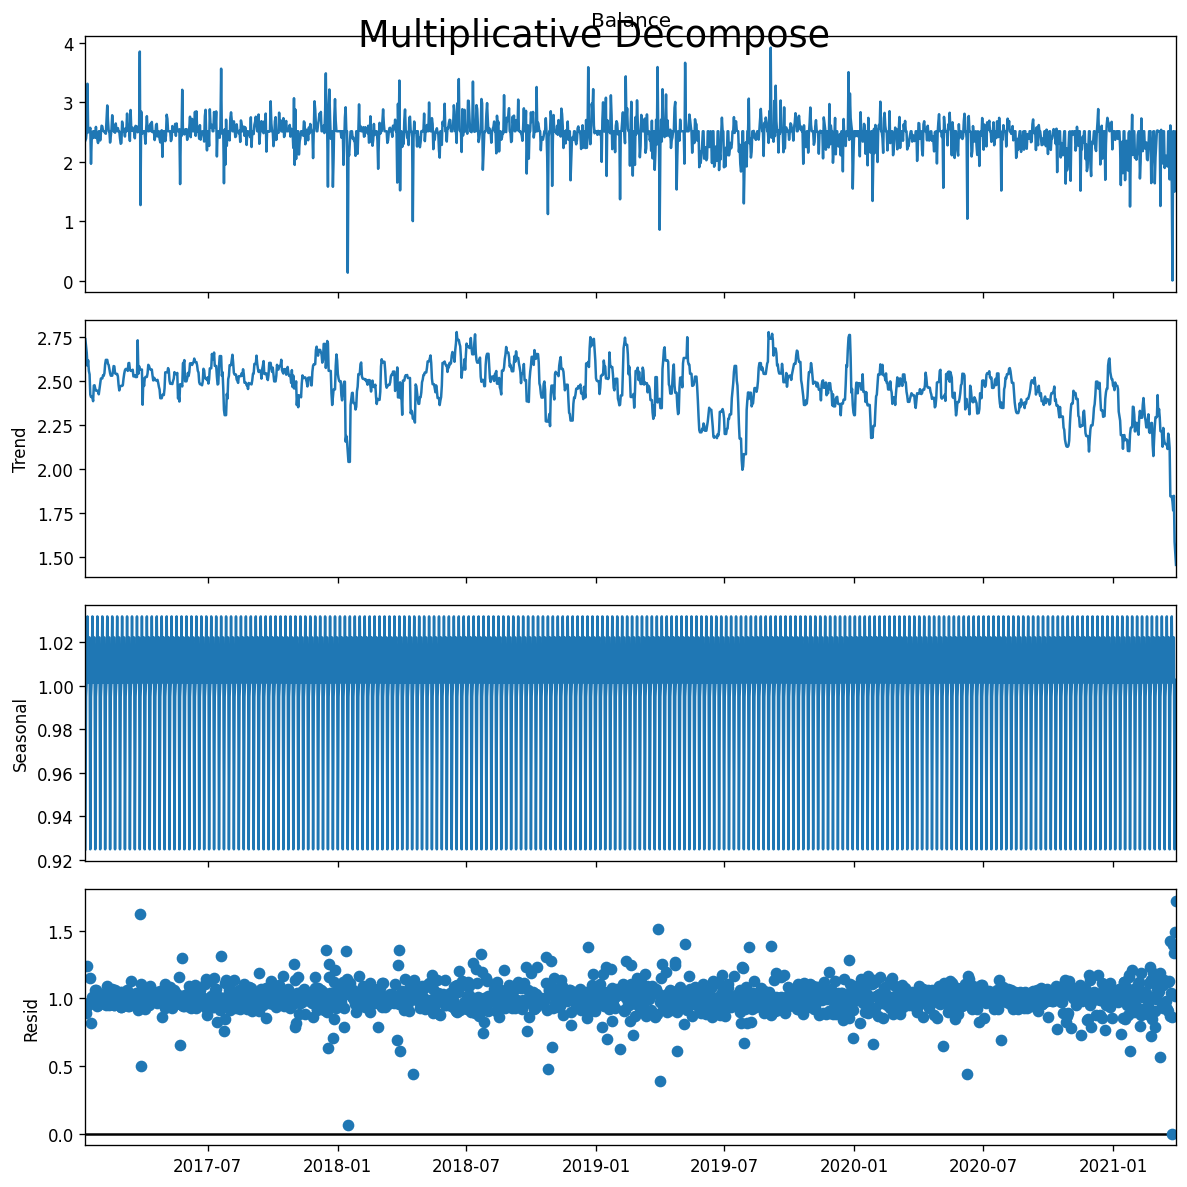

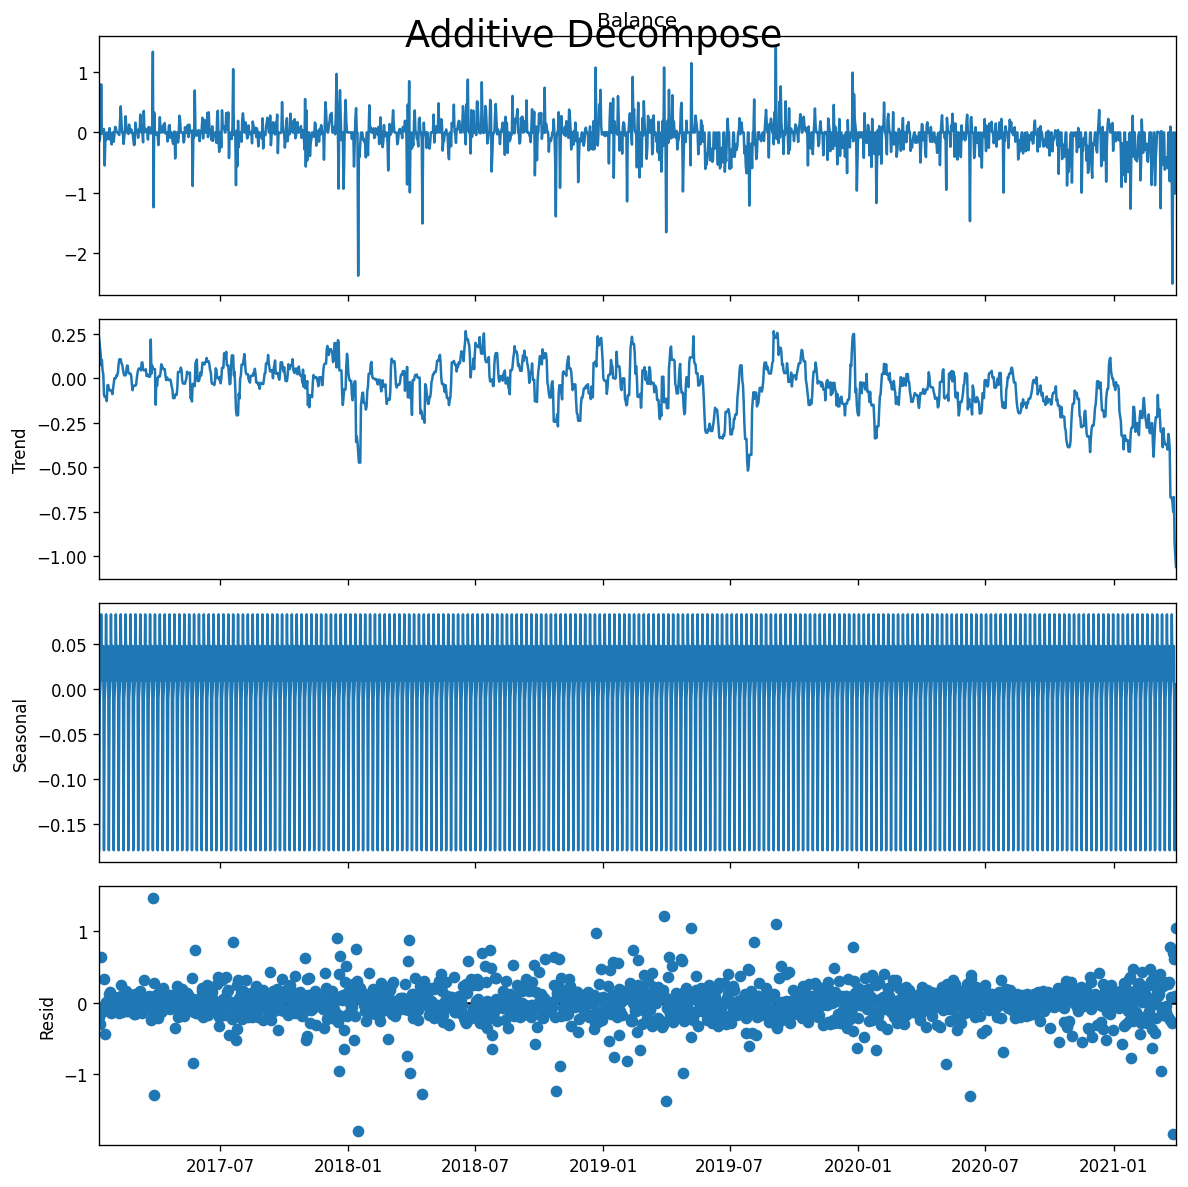

In [29]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(data_origin['Balance'] + abs(data_origin['Balance'].min())+0.000001, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(data_origin['Balance'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [30]:
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Date,,,,
2017-01-09,0.924902,2.738203,0.931459,2.358984
2017-01-10,0.994942,2.699560,0.889576,2.389315
2017-01-11,1.002635,2.660917,0.945548,2.522654
2017-01-12,1.031763,2.587311,1.241914,3.315278
2017-01-13,1.001498,2.617868,0.951704,2.495166


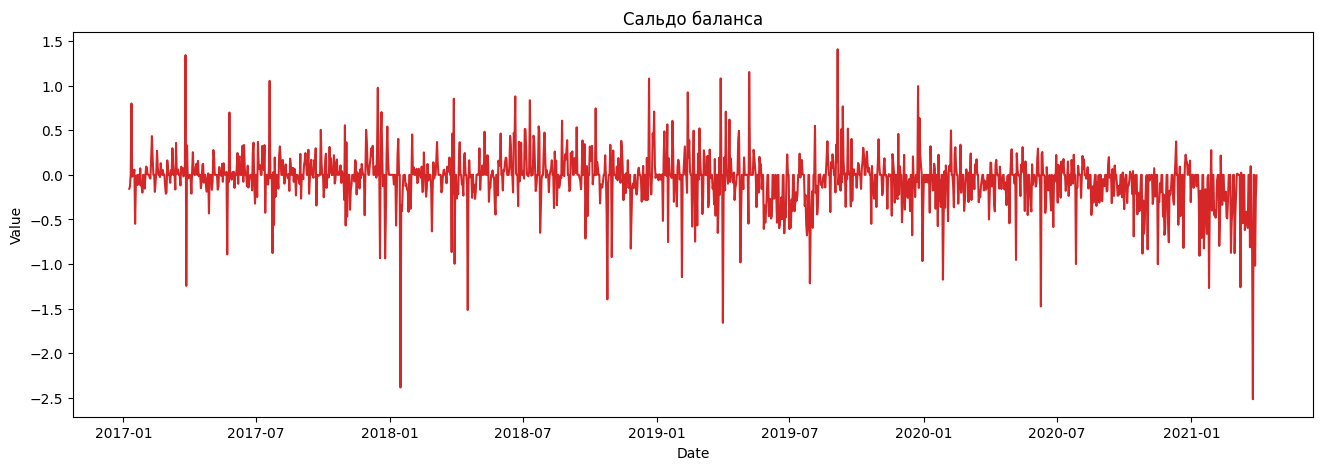

In [31]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(data_origin, x=data.index, y=data.Balance, title='Сальдо баланса')    


# Проверка стационарности:

- Пристальное вглядывание в график временного ряда
- Разбиение на части и подсчет статистик
- Тесты на единичные корни
- Dickey Fuller test (ADH Test)
- Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
- Philips Perron test (PP Test)

In [32]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

def stationarity_check(data: pd.Series) -> None:
    """
    Проверяет стационарность временного ряда с помощью тестов ADF, KPSS и Phillips-Perron.
    Выводит статистику, p-значения и заключение о стационарности после каждого теста.
    Также анализирует среднее и дисперсию двух половин ряда.

    Parameters:
    -----------
    data : pd.Series
        Входные данные (временной ряд). Должен быть типа pandas.Series.
    """
    if not isinstance(data, pd.Series):
        raise ValueError("Входные данные должны быть типа pandas.Series")
    
    df = data.sort_index().dropna()
    
    if len(df) < 2:
        raise ValueError("Недостаточно данных для анализа стационарности")
    
    midpoint = len(df) // 2
    df_first_half = df.iloc[:midpoint]
    df_second_half = df.iloc[midpoint:]

    mean_first = df_first_half.mean()
    var_first = df_first_half.var()
    mean_second = df_second_half.mean()
    var_second = df_second_half.var()

    print("\n=== Анализ среднего и дисперсии ===")
    print(f"Первая половина - Среднее: {mean_first:.4f}, Дисперсия: {var_first:.4f}")
    print(f"Вторая половина - Среднее: {mean_second:.4f}, Дисперсия: {var_second:.4f}")
    
    if abs(mean_first - mean_second) > 0.1 * abs(mean_first) or abs(var_first - var_second) > 0.1 * abs(var_first):
        print("Различия в среднем или дисперсии указывают на возможную нестационарность.")
    else:
        print("Среднее и дисперсия стабильны, что может указывать на стационарность.")

    print("\n=== Тест Дики-Фуллера (ADF) ===")
    adf_result = adfuller(df)
    print(f"Статистика теста: {adf_result[0]:.4f}")
    print(f"p-значение: {adf_result[1]:.4f}")
    print(f"Критические значения: {adf_result[4]}")
    adf_stationary = adf_result[1] < 0.05 and adf_result[0] < adf_result[4]['5%']
    print(f"Заключение: Ряд {'стационарен' if adf_stationary else 'нестационарен'} по тесту ADF.")

    print("\n=== Тест KPSS (трендовая стационарность) ===")
    kpss_result = kpss(df, regression='ct')
    print(f"Статистика теста: {kpss_result[0]:.4f}")
    print(f"p-значение: {kpss_result[1]:.4f}")
    print(f"Критические значения: {kpss_result[3]}")
    kpss_stationary = kpss_result[1] >= 0.05
    print(f"Заключение: Ряд {'стационарен' if kpss_stationary else 'нестационарен'} по тесту KPSS.")

    print("\n=== Тест Филлипса-Перрона (PP) ===")
    pp = PhillipsPerron(df)
    print(pp.summary())
    pp_stationary = pp.pvalue < 0.05
    print(f"Заключение: Ряд {'стационарен' if pp_stationary else 'нестационарен'} по тесту PP.")

    print("\n=== Итоговый вывод ===")
    if adf_stationary and pp_stationary and not kpss_stationary:
        print("Расхождение тестов: Ряд, вероятно, стационарен после удаления тренда.")
    elif adf_stationary and pp_stationary and kpss_stationary:
        print("Ряд стационарен по всем тестам.")
    elif not adf_stationary and not pp_stationary and not kpss_stationary:
        print("Ряд нестационарен по всем тестам.")
    else:
        print("Тесты дают противоречивые результаты. Рекомендуется дополнительный анализ.")

In [33]:
stationarity_check(data_origin['Balance'])


=== Анализ среднего и дисперсии ===
Первая половина - Среднее: 0.0089, Дисперсия: 0.0725
Вторая половина - Среднее: -0.1065, Дисперсия: 0.0914
Различия в среднем или дисперсии указывают на возможную нестационарность.

=== Тест Дики-Фуллера (ADF) ===
Статистика теста: -4.1141
p-значение: 0.0009
Критические значения: {'1%': np.float64(-3.4346537865963596), '5%': np.float64(-2.8634408535813285), '10%': np.float64(-2.5677819879092625)}
Заключение: Ряд стационарен по тесту ADF.

=== Тест KPSS (трендовая стационарность) ===
Статистика теста: 0.3539
p-значение: 0.0100
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Заключение: Ряд нестационарен по тесту KPSS.

=== Тест Филлипса-Перрона (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -39.428
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothe

/var/folders/85/s3wbgppx3bd4pz8hvr_pjl7m0000gn/T/ipykernel_73295/1919798344.py:50: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df, regression='ct')


**Анализ статистик (среднее и дисперсия)**
- Среднее значение изменилось с положительного в первой половине на отрицательное во второй, что указывает на возможное изменение тренда или уровня ряда.
- Дисперсия увеличилась, что говорит о росте волатильности во второй половине.
- Эти различия свидетельствуют о нестационарности ряда, так как стационарный ряд должен иметь постоянные среднее и дисперсию во времени.

**Тест Дики-Фуллера (ADF)**
- Статистика теста меньше критических значений.
- p-значение** < 0.05.
Ряд **стационарен** согласно тесту ADF.

**Тест KPSS (трендовая стационарность)**
- Статистика теста больше критических значений.
- p-значение < 0.05.
Ряд **нестационарен** по тесту KPSS.

**Тест Филлипса-Перрона (PP)**
- Статистика теста значительно меньше критических значений.
- p-значение < 0.05.
- Ряд **стационарен** согласно тесту PP.

Расхождение тестов свидетельствует о том, что ряд стационарен после удаления тренда.

In [34]:
stationarity_check(data_origin['Income'])


=== Анализ среднего и дисперсии ===
Первая половина - Среднее: 0.9793, Дисперсия: 0.5624
Вторая половина - Среднее: 1.1904, Дисперсия: 0.8227
Различия в среднем или дисперсии указывают на возможную нестационарность.

=== Тест Дики-Фуллера (ADF) ===
Статистика теста: -5.4000
p-значение: 0.0000
Критические значения: {'1%': np.float64(-3.434656620970318), '5%': np.float64(-2.863442104538126), '10%': np.float64(-2.5677826540508275)}
Заключение: Ряд стационарен по тесту ADF.

=== Тест KPSS (трендовая стационарность) ===
Статистика теста: 0.1176
p-значение: 0.1000
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Заключение: Ряд стационарен по тесту KPSS.

=== Тест Филлипса-Перрона (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -26.825
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: 

/var/folders/85/s3wbgppx3bd4pz8hvr_pjl7m0000gn/T/ipykernel_73295/1919798344.py:50: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df, regression='ct')


In [35]:
stationarity_check(data_origin['Outcome'])


=== Анализ среднего и дисперсии ===
Первая половина - Среднее: 0.9704, Дисперсия: 0.5685
Вторая половина - Среднее: 1.2968, Дисперсия: 1.0058
Различия в среднем или дисперсии указывают на возможную нестационарность.

=== Тест Дики-Фуллера (ADF) ===
Статистика теста: -4.0097
p-значение: 0.0014
Критические значения: {'1%': np.float64(-3.434656620970318), '5%': np.float64(-2.863442104538126), '10%': np.float64(-2.5677826540508275)}
Заключение: Ряд стационарен по тесту ADF.

=== Тест KPSS (трендовая стационарность) ===
Статистика теста: 0.0806
p-значение: 0.1000
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Заключение: Ряд стационарен по тесту KPSS.

=== Тест Филлипса-Перрона (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -29.546
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: 

/var/folders/85/s3wbgppx3bd4pz8hvr_pjl7m0000gn/T/ipykernel_73295/1919798344.py:50: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df, regression='ct')


**Взятие разности** <br>
Важный трюк, который позволяет сделать ряд стационарным, — это дифференцирование, переход к попарным разностям соседних значений:
$$y' = y_t − y_{t−1}$$
Для нестационарного ряда часто оказывается, что получаемый после дифференцирования ряд является
стационарным. <br>
Дифференцирование можно применять неоднократно: от ряда первых
разностей, продифференцировав его, можно прийти к ряду вторых разностей, и т. д. <br>
Также может применяться сезонное дифференцирование ряда, переход к попарным разностям значений
в соседних сезонах. Если длина периода сезона составляет s, то новый ряд задаётся разностями
$$y'_t = y_t − y_{t−s}.$$
Сезонное и обычное дифференцирование могут применяться к ряду в любом порядке. Однако если у ряда
есть ярко выраженный сезонный профиль, то рекомендуется начинать с сезонного дифференцирования, уже
после такого преобразования может оказаться, что ряд стационарен.


In [40]:
data_diff = data_origin.copy()
data_diff['Balance'] = data_origin['Balance'].diff().dropna()
data_diff = data_diff.iloc[1:]
data_diff.head()

,Income,Outcome,Balance
Date,,,
2017-01-10,1.068610,1.194182,0.030332
2017-01-11,0.944429,0.936663,0.133339
2017-01-12,1.672202,0.875379,0.792624
2017-01-13,0.955924,0.975645,-0.820112
2017-01-14,0.000000,0.000000,0.019721


In [42]:
stationarity_check(data_diff['Balance'])


=== Анализ среднего и дисперсии ===
Первая половина - Среднее: 0.0004, Дисперсия: 0.1389
Вторая половина - Среднее: -0.0002, Дисперсия: 0.1530
Различия в среднем или дисперсии указывают на возможную нестационарность.

=== Тест Дики-Фуллера (ADF) ===
Статистика теста: -14.7654
p-значение: 0.0000
Критические значения: {'1%': np.float64(-3.4346537865963596), '5%': np.float64(-2.8634408535813285), '10%': np.float64(-2.5677819879092625)}
Заключение: Ряд стационарен по тесту ADF.

=== Тест KPSS (трендовая стационарность) ===
Статистика теста: 0.0449
p-значение: 0.1000
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Заключение: Ряд стационарен по тесту KPSS.

=== Тест Филлипса-Перрона (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic               -178.792
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothes

/var/folders/85/s3wbgppx3bd4pz8hvr_pjl7m0000gn/T/ipykernel_73295/1919798344.py:50: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df, regression='ct')


**Стабилизация дисперсии**

В случае, если во временном ряде монотонно по времени изменяется дисперсия, применяется специальное преобразование, стабилизирующее дисперсию.

 Очень часто в качестве такого преобразования выступает логарифмирование. 
 
Логарифмирование принадлежит к семейству преобразований Бокса-Кокса.

$$y_t' =\begin{cases}
\ln y_t, \lambda=0 \\
(y_t^\lambda - 1)/\lambda, \lambda \neq 0
\end{cases} $$


Это параметрическое семейство функций, в котором параметр λ определяет, как именно будет преобразован
ряд: 

λ = 0 — это логарифмирование, 

λ = 1 — тождественное преобразование ряда, 

а при других значениях
λ — степенное преобразование.

 Значение параметра можно подбирать так, чтобы дисперсия была как можно
более стабильной во времени.


# Обоснование выбора метрики для оптимизации

Для выбора метрики важно понимать последствия ошибок. 
- Недооценка сальдо (прогноз ниже фактического). Отсутсвие возможности разместить больше средств на рынке деривативов. То есть потери прибыли в размере = value * (credit_rate + 0.5)/365.
- Переоценка сальдо (прогноз выше фактического). Допуск дефицит, что приведет к необходимости заимствования по высокой ставке (ключ + 1%), увеличивая затраты. То есть потери прибыли в размере = value * (credit_rate + 1)/365.

Ошибка по переоценке сальдо имеет большие потери, но оба варианта сильно зависят от разницы между прогнозом и фактическим значением

Рассмотрим несколько метрик и их применимость:

**MAE (Mean Absolute Error)**:
- Непосредственно измеряет среднюю абсолютную ошибку, что соответствует требованию заказчика (ошибка ≤ 0.42).
- Показывает среднее отклонение прогноза от фактического сальдо.
- Устойчива к знаку ошибки, что важно для сальдо, которое может быть положительным или отрицательным.
- Линейно штрафует ошибки, что отражает финансовые последствия, так как затраты/упущенная выгода пропорциональны величине ошибки.
- Не учитывает квадратичные эффекты, если крупные ошибки имеют непропорционально большие последствия.


**MSE (Mean Squared Error)**:
- Сильнее штрафует большие ошибки из-за квадратичной зависимости, что может быть полезно, если крупные отклонения критичны.
- Менее интерпретируема в контексте требования заказчика (0.42 в абсолютном значении).
- Чувствительна к выбросам, что может исказить оптимизацию, если в данных есть аномалии (например, в налоговые дни).

**RMSE (Root Mean Squared Error)**:
- Сохраняет интерпретируемость в единицах исходной переменной (как MAE).
- Учитывает большие ошибки сильнее, чем MAE.

**Custom Loss (асимметричная потеря)**:<br>
Можно разработать метрику, которая по-разному штрафует переоценку и недооценку сальдо, учитывая разницу в доходности/затратах (например, +0.5% для деривативов vs. +1% для заимствований).
- Точно отражает финансовые последствия.
- Сложнее реализовать и оптимизировать.

В датасете есть дни с нулевым сальдо (выходные), а также аномалии (налоговые дни). MAE менее чувствительна к выбросам, чем MSE или RMSE, что делает ее более стабильной для оптимизации, еще MAE легко объяснить бизнесу - средняя ошибка в единицах сальдо.

**Как избавиться от тренда?**

- Воспользоваться линейной регрессией на шаг временного ряда ( используя также степенные компоненты)
- Вычесть среднее
- Baxter-King filter(statsmodels.tsa.filters.bkfilter) или Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) чтобы убрать среднее или циклическую компоненту

Text(0.5, 1.0, 'Сальдо балансов')

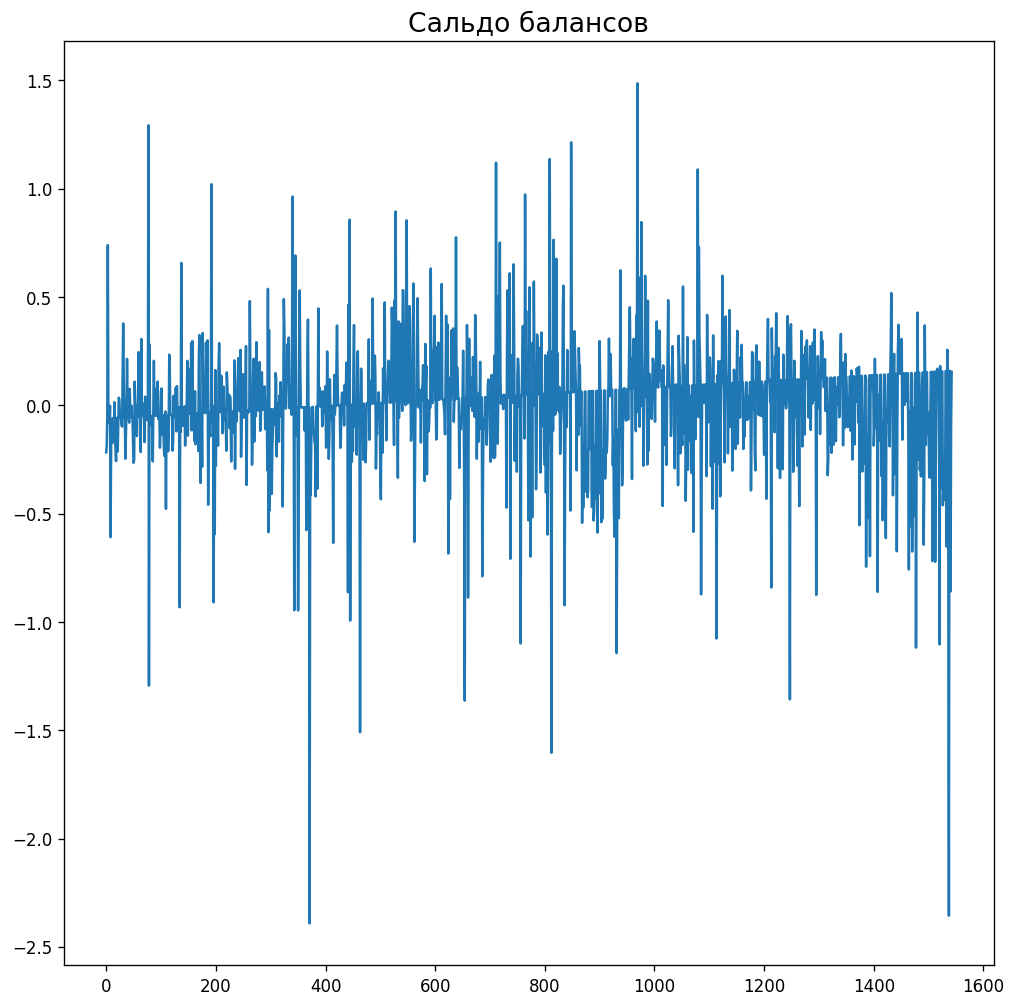

In [43]:
from scipy import signal

detrended = signal.detrend(data_origin['Balance'])
plt.plot(detrended)
plt.title('Сальдо балансов', fontsize=16)

Text(0.5, 1.0, 'Сальдо балансов')

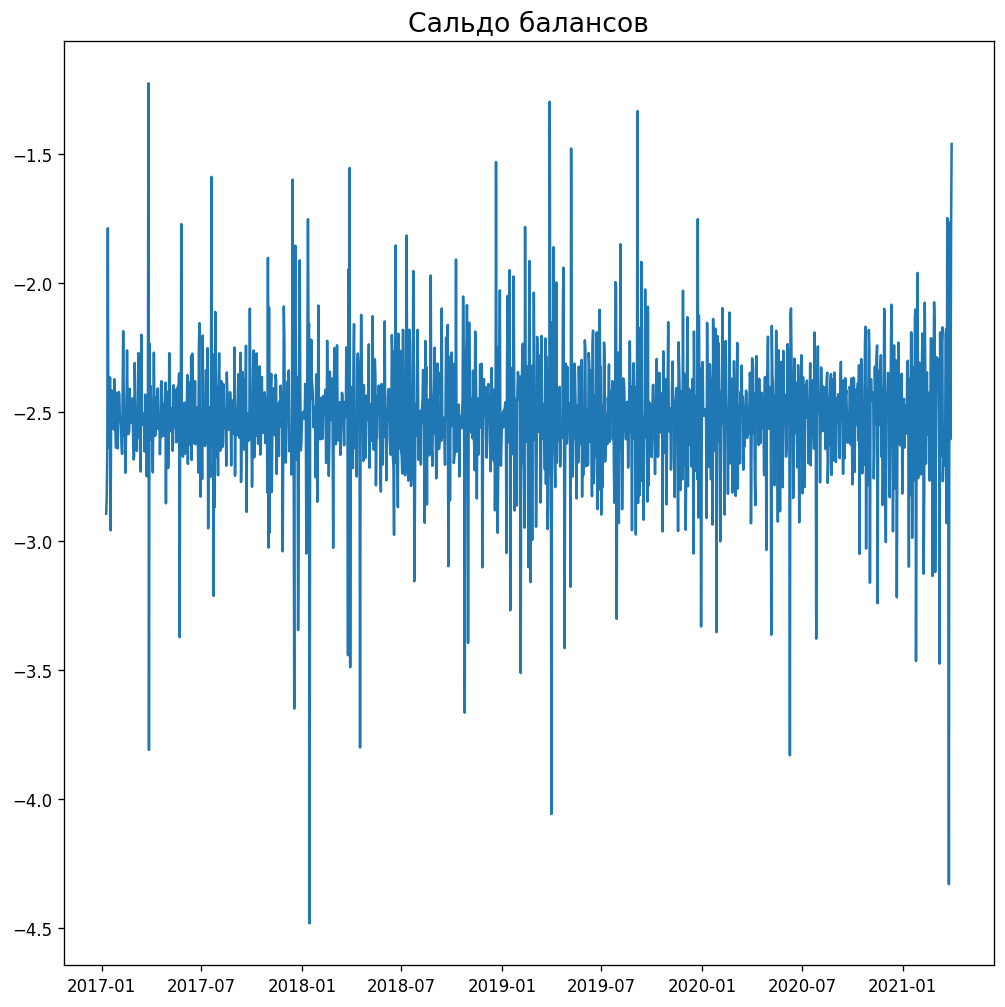

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(data_origin['Balance'] + abs(data_origin['Balance'].min())+0.000001, model='multiplicative', extrapolate_trend='freq')
detrended = data_origin['Balance'] - result_mul.trend
plt.plot(detrended)
plt.title('Сальдо балансов', fontsize=16)

Тяжело выделить тренд визуально.

# Как учесть сезонность?


- 1. Скользящее среднее с сезонным окном. 

- 2. Сезонные разности

- 3. Разбить ряд по временным индексами

[]

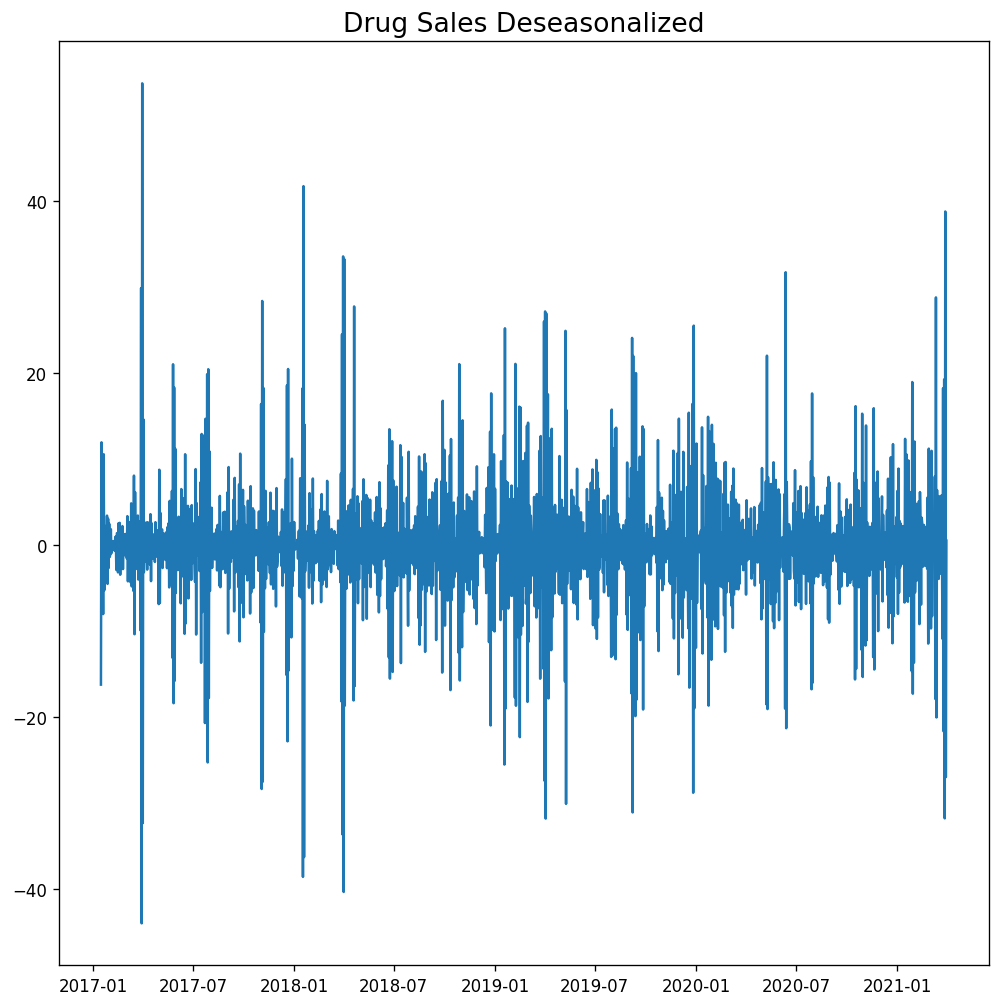

In [68]:

# Time Series Decomposition
result_mul = seasonal_decompose(df['Balance'] + abs(df['Balance'].min())+0.000001, model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df['Balance'] / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=16)
plt.plot()

# Тест на сезонность:

- По часам
- По дням (месяца)
- По неделям
- По месяцам
- По годам

- На графике ACF ( пики на 12,24,36 периоде).

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

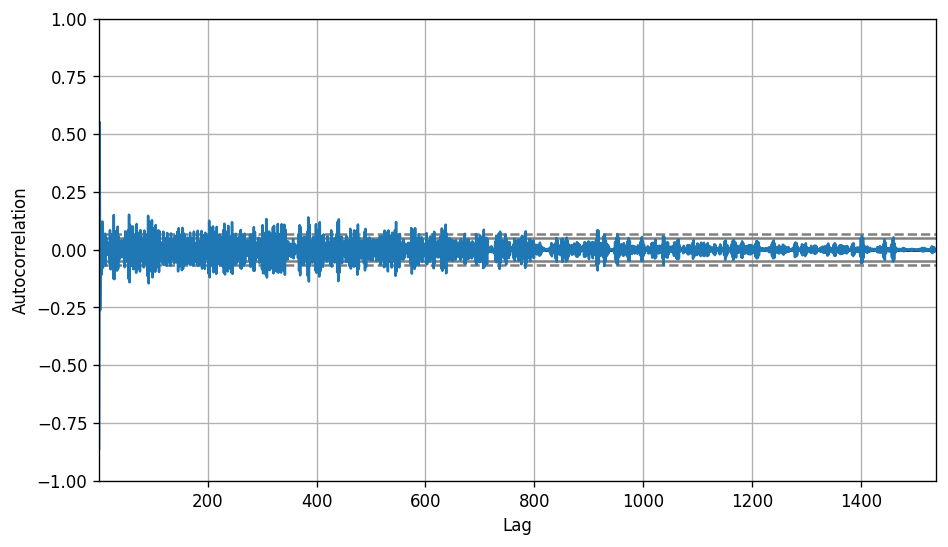

In [69]:
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})

autocorrelation_plot(df['Balance'])

# ACF PCF

# ACF

Количественной характеристикой сходства между значениями ряда в соседних точках является автокорреляционная функция (или просто автокорреляция), которая задаётся следующим соотношением:
$$r_τ = \frac{E((y_t − Ey)(y_{t-τ} − Ey))}{Dy}$$

**Автокорреляция** — это уже встречавшаяся ранее корреляция Пирсона между исходным рядом и его версией,
сдвинутой на несколько отсчётов. Количество отсчётов, на которое сдвинут ряд, называется лагом автокорреляции (τ ).

Вычислить автокорреляцию по выборке можно, заменив в формуле математическое ожидание на выборочное среднее, а дисперсию — на выборочную дисперсию.

Анализировать величину автокорреляции при разных значениях лагов удобно с помощью графика, который называется коррелограммой. По оси ординат на нём откладывается автокорреляция, а по оси абсцисс —
размер лага τ.

Как и для обычной корреляции Пирсона,
значимость вычисляется с помощью критерия Стьюдента. Альтернатива чаще всего двусторонняя, потому что при анализе временных рядов крайне редко имеется гипотеза о том, какой должна быть
корреляция, положительной или отрицательной.


временной ряд: $y^T = y_1, . . . , y_T$

нулевая гипотеза: $H_0 : r_τ = 0$

альтернатива: $H_1 : r_τ \neq 0$

статистика: $T(y^T) =\frac{ r_τ \sqrt{T - τ−2}}{\sqrt{1−r^2_τ}};$

нулевое распределение: $T(y^T) ∼ St(T − τ − 2).$





# PACF

Частичная автокорреляция - это сводка взаимосвязи между наблюдением во временном ряду с наблюдениями на предыдущих временных этапах с удалением взаимосвязей между промежуточными наблюдениями.

**Частичная автокорреляция** при лаге k - это корреляция, возникающая после устранения влияния любых корреляций, связанных с членами с более короткими лагами.


Поскольку автоковариация стационарного  ряда зависит только от сдвига, то и автокорреляция – это функция только сдвига k,
$$ρ(k) = \frac{cov(y_t, y_{t−k} )}{σ^2_y} = \frac{γ(k)}{γ(0)}, k ≥ 0.$$


 По сути, вместо того, чтобы находить корреляции настоящего с лагами, такими как ACF, он находит корреляцию остатков (которая сохраняется после устранения эффектов, которые уже были объяснены более ранним лагом (ами)) со следующим значением лага, следовательно, «частичным», а не «полным». 
 


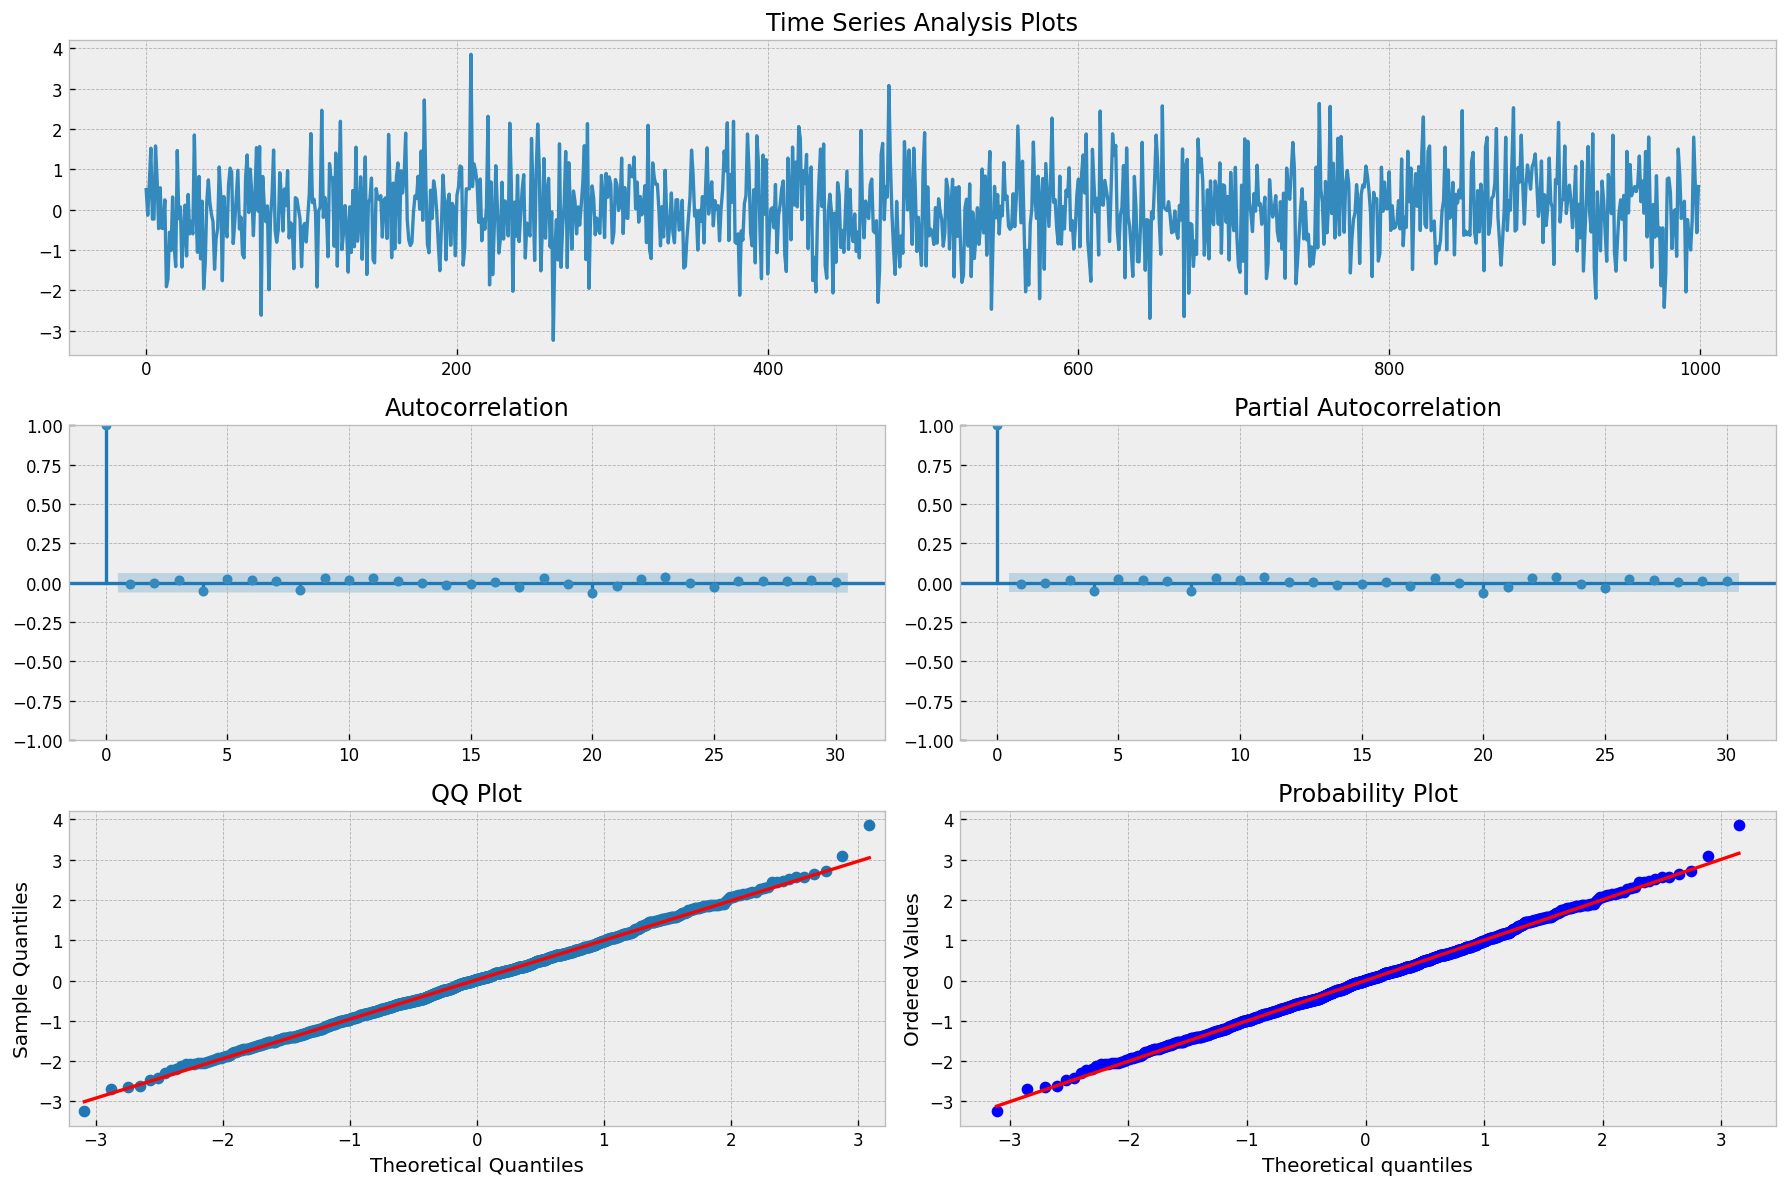

In [70]:

def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

np.random.seed(42)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)


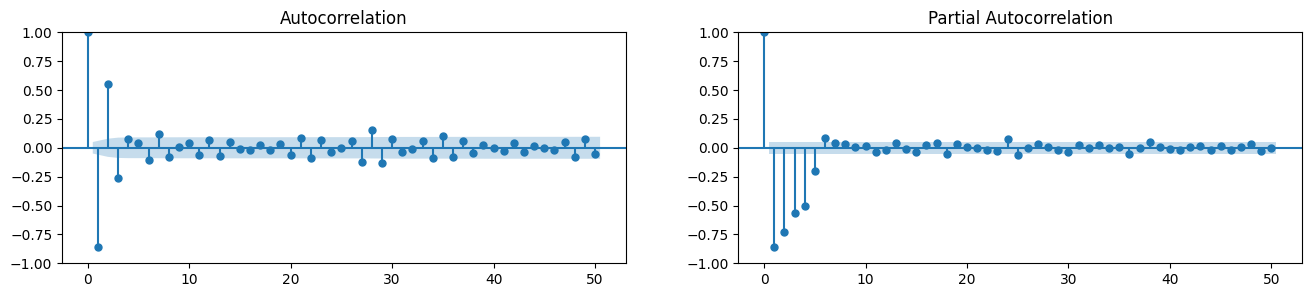

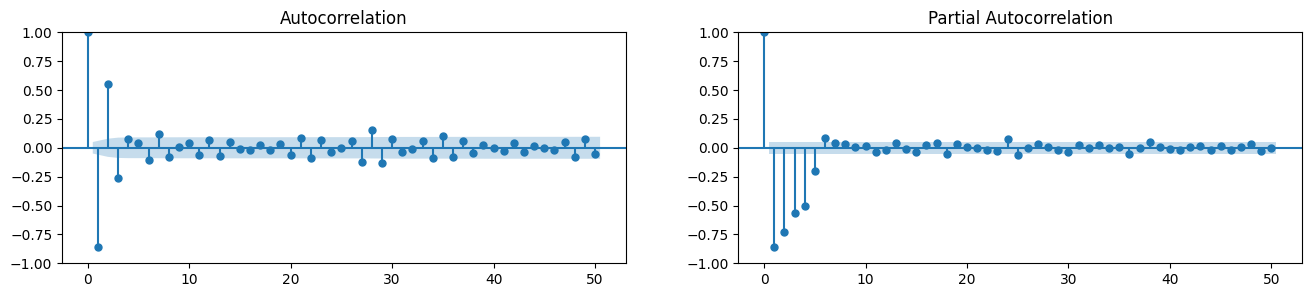

In [71]:

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['Balance'], lags=50, ax=axes[0])
plot_pacf(df['Balance'], lags=50, ax=axes[1])

# Авторегрессия


Можно перейти к следующей идее: делать регрессию для ряда не на какие-то внешние признаки, зависящие
от времени, а на его собственные значения в прошлом:

$$y_t = α + φ_1 y_{t−1} + φ_2 y_{t−2} + · · · + φ_p y_{t−p} + ε_t.$$

В этом регрессионном уравнении $y_t$ — это отклик, $y_{t−1}, y_{t−2},\dots , y_{t−p}$ — признаки, $α, φ_1, φ_2, . . . , φ_p$ — параметры
модели, которые необходимо оценить, $ε_t$ — шумовая компонента, описывает отклонения значений ряда от
данного уравнения.


Такая модель называется моделью авторегрессии порядка p (AR(p)). В этой модели $y_t$ представляет собой
линейную комбинацию p предыдущих значений ряда и шумовой компоненты.



In [ ]:
# Simulate an AR(1) process with alpha = 0.6

n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)
lags = 30
for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=lags)

# Feature Engineering

In [ ]:
def create_balance_features(df, target_col='Balance'):
    """
    Создает фичи из таргета Balance: лаги, скользящие средние, разности и др.
    
    Parameters:
    df (pd.DataFrame): DataFrame с данными, содержащий столбец Balance
    target_col (str): Название столбца таргета (по умолчанию 'Balance')
    
    Returns:
    pd.DataFrame: DataFrame с новыми фичами
    """
    df = df.copy()
    
    # Лаги (1, 2, 3, 7 дней назад)
    for lag in [1, 2, 3, 7]:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
        
    # Rolling Statistics
   
    windows = [3, 7, 14]

    for window in windows:
        # Скользящие средние
        df[f'roll_mean_{window}'] = df[target_col].rolling(window=window, min_periods=1).mean()
        # Скользящее стандартное отклонение
        df[f'roll_std_{window}'] = df[target_col].rolling(window=window, min_periods=1).std()
        # Скользящий минимум
        df[f'roll_min_{window}'] = df[target_col].rolling(window=window, min_periods=1).min()
        # Скользящий максимум
        df[f'roll_max_{window}'] = df[target_col].rolling(window=window, min_periods=1).max()
        # Скользящая сумма
        df[f'roll_sum_{window}'] = df[target_col].rolling(window=window, min_periods=1).sum()
    
    # Разности (первого порядка)
    df['diff_1'] = df[target_col].diff(1)
    df['diff_2'] = df[target_col].diff(2)
    
    # Кумулятивная сумма и среднее
    df['cumsum'] = df[target_col].cumsum()
    df['cummean'] = df[target_col].expanding().mean()
    
    # Отношение текущего значения к скользящему среднему
    for window in [3, 7]:
        df[f'ratio_ma_{window}'] = df[target_col] / df[f'roll_mean_{window}']
    
    # Отношение к предыдущему значению
    df['ratio_lag_1'] = df[target_col] / df[f'lag_1']
    
    data[data == np.inf] = 1e10
    data[data == -np.inf] = -1e10
    df = df.dropna()
    
    return df

data = create_balance_features(data)
data.head()

,Income,Outcome,Balance,lag_1,lag_2,lag_3,lag_7,roll_mean_3,roll_std_3,roll_min_3,...,roll_min_14,roll_max_14,roll_sum_14,diff_1,diff_2,cumsum,cummean,ratio_ma_3,ratio_ma_7,ratio_lag_1
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-16,1.082341,1.024345,0.057996,0.000000,0.000000,-0.019721,-0.155904,0.019332,0.033484,0.000000,...,-0.155904,0.800391,0.564957,0.057996,0.057996,0.564957,0.070620,3.000000,0.563181,inf
2017-01-17,0.896334,1.448364,-0.548519,0.057996,0.000000,0.000000,-0.125572,-0.163507,0.334688,-0.548519,...,-0.548519,0.800391,0.016438,-0.606515,-0.548519,0.016438,0.001826,3.354702,-12.888378,-9.457799
2017-01-18,0.754759,0.879560,-0.124801,-0.548519,0.057996,0.000000,0.007767,-0.205108,0.311130,-0.548519,...,-0.548519,0.800391,-0.108363,0.423717,-0.182798,-0.108363,-0.010836,0.608467,-5.283515,0.227524
2017-01-19,0.949877,0.955268,-0.005391,-0.124801,-0.548519,0.057996,0.800391,-0.226237,0.285419,-0.548519,...,-0.548519,0.800391,-0.113754,0.119411,0.543128,-0.113754,-0.010341,0.023828,0.058921,0.043194
2017-01-20,1.024187,1.138087,-0.113900,-0.005391,-0.124801,-0.548519,-0.019721,-0.081364,0.066020,-0.124801,...,-0.548519,0.800391,-0.227654,-0.108510,0.010901,-0.227654,-0.018971,1.399883,1.085334,21.129018


In [82]:
data.columns

Index(['Income', 'Outcome', 'Balance', 'lag_1', 'lag_2', 'lag_3', 'lag_7',
       'roll_mean_3', 'roll_std_3', 'roll_min_3', 'roll_max_3', 'roll_sum_3',
       'roll_mean_7', 'roll_std_7', 'roll_min_7', 'roll_max_7', 'roll_sum_7',
       'roll_mean_14', 'roll_std_14', 'roll_min_14', 'roll_max_14',
       'roll_sum_14', 'diff_1', 'diff_2', 'cumsum', 'cummean', 'ratio_ma_3',
       'ratio_ma_7', 'ratio_lag_1'],
      dtype='object')

# добавление макроэкономических факторов

- ключевая ставка 
- инфляция ((((посмотреть еще))))
- MosPrime
- индекс moex
- даты налоговых дней

In [70]:
credit_rate_inflation = pd.read_excel('Инфляция и ключевая ставка Банка России_F01_01_2017_T25_04_2025.xlsx')
credit_rate_inflation.shape

(99, 4)

In [71]:
credit_rate_inflation

,Дата,"Ключевая ставка, % годовых","Инфляция, % г/г",Цель по инфляции
0,3.2025,21.00,10.34,4
1,2.2025,21.00,10.06,4
2,1.2025,21.00,9.92,4
3,12.2024,21.00,9.52,4
4,11.2024,21.00,8.88,4
...,...,...,...,...
94,5.2017,9.25,4.10,4
95,4.2017,9.75,4.10,4
96,3.2017,9.75,4.30,4
97,2.2017,10.00,4.60,4


In [72]:
credit_rate = pd.read_excel('Инфляция и ключевая ставка Банка России_F01_01_2017_T25_04_2025.xlsx')
credit_rate

,Дата,"Ключевая ставка, % годовых","Инфляция, % г/г",Цель по инфляции
0,3.2025,21.00,10.34,4
1,2.2025,21.00,10.06,4
2,1.2025,21.00,9.92,4
3,12.2024,21.00,9.52,4
4,11.2024,21.00,8.88,4
...,...,...,...,...
94,5.2017,9.25,4.10,4
95,4.2017,9.75,4.10,4
96,3.2017,9.75,4.30,4
97,2.2017,10.00,4.60,4


Добавить дф про ключевую ставку. размещение и займ

на нее мы домножаем баланс на следующий день

# Модуль детекции аномалий

### 1. Одноклассовый метод опорных векторов


Будем строить линейную функцию $a(x) = sign \langle w, x \rangle$, и потребуем,
чтобы она отделяла выборку от начала координат с максимальным отступом.
Соответствующая оптимизационная задача будет иметь следующий вид:

$$
\left\{
        \begin{aligned}
            & \frac{1}{2} \|w\|^2
            +
            \frac{1}{\nu \ell} \sum_{i = 1}^{\ell} \xi_i
            -
            \rho
            \to \min_{w, \xi, \rho} \\
            & \langle w, x_i \rangle
            \geq
            \rho - \xi_i,
            \quad i = 1, \dots, \ell, \\
            & \xi_i \geq 0, \quad i = 1, \dots, \ell.
        \end{aligned}
\right.
$$


Здесь гиперпараметр $\nu$ отвечает за корректность на обучающей выборке -
можно показать, что он является верхней границей на число аномалий (объектов выборки,
на которых $a(x) = -1$).
Решающее правило будет иметь вид

$$
\
    a(x)
    =
    sign\left(
        \langle w, x \rangle
        -
        \rho
    \right),
\
$$
где ответ -1 будет соответствовать выбросу.

### 2. Isolation forest

На этапе обучения будем строить лес, состоящий из N деревьев.
Каждое дерево будем строить стандартным жадным алгоритмом,
но при этом признак и порог будем выбирать случайно.
Строить дерево будем до тех пор, пока в вершине не окажется ровно один объект,
либо пока не будет достигнута максимальная высота.


Метод основан на предположении о том, что чем сильнее объект отличается от большинства,
тем быстрее он будет отделён от основной выборки с помощью случайных разбиений.
Соответственно, выбросами будем считать те объекты, которые оказались на небольшой глубине.

Чтобы вычислить оценку аномальности объекта $x$, найдём расстояние от соответствующего ему листа
до корня в каждом дереве.
Если лист, в котором оказался объект, содержит только его, то в качестве оценки $h_n(x)$
от данного $n$-го дерева будем брать саму глубину $k$;
если же в листе оказалось $m$ объектов, то в качестве оценки возьмём величину $h_n(x) = k + c(m)$.
Здесь $c(m)$ - средняя длина пути от корня до листа в бинарном дереве поиска, которая вычисляется по формуле
$$
\
    c(m)
    =
    2H(m - 1) - 2\frac{m - 1}{m},
\
$$
а $H(i) \approx \ln(i) + 0.5772156649$ - $i$-е гармоническое число.
Оценку аномальности вычислим на основе средней глубины, нормированной на среднюю длину пути в дереве,
построенном на выборке размера $\ell$:
$$
\
    a(x)
    =
    2^{-\frac{
            \frac{1}{N} \sum_{n = 1}^{N} h_n(x)
        }{
            c(\ell)
        }
    }.
\
$$


### 3. Метрический метод LOF (Local Outlier Factor)

Суть метода: измерение локального отклонения плотности конкретной точки данных по отношению к ее соседям. Идея состоит в том, чтобы обнаружить наблюдения, которые имеют значительно меньшую плотность, чем их соседи. Именно эти точки и будут являться аномалиями. 

In [ ]:
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.pipeline import make_pipeline

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared.


anomaly_algorithms = [
    
    ("One-Class SVM", OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),

    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
    14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

Обнаружено аномалий: 45 из 45 добавленных аномалий


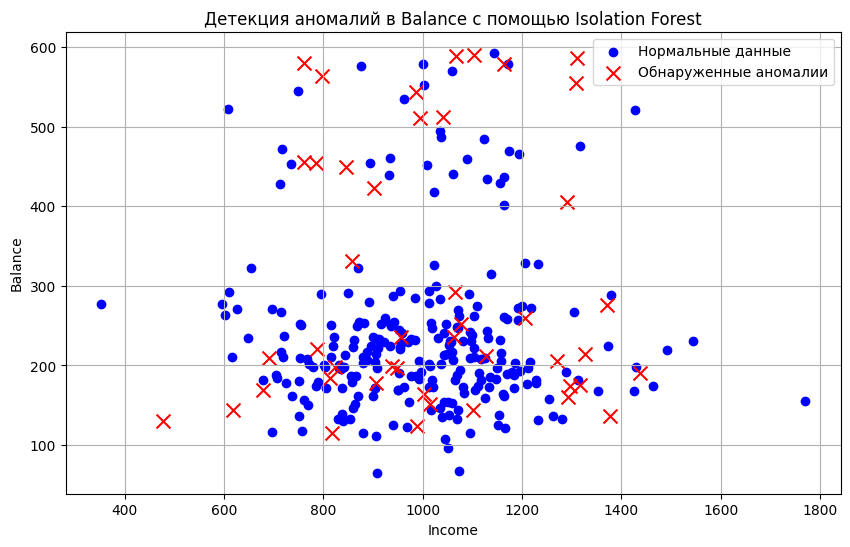

In [ ]:
from sklearn.ensemble import IsolationForest

# Предполагается, что данные уже загружены в DataFrame
# Если данных нет, замените на реальный путь к файлу или DataFrame
# Пример: df = pd.read_csv('your_data.csv')
# Для демонстрации создадим синтетический DataFrame
np.random.seed(42)
n_samples = 300
df = pd.DataFrame({
    'Income': np.random.normal(1000, 200, n_samples),
    'Outcome': np.random.normal(800, 150, n_samples),
    'Balance': np.random.normal(200, 50, n_samples),
    'lag_1': np.random.normal(200, 50, n_samples),
    'lag_2': np.random.normal(200, 50, n_samples),
    'lag_3': np.random.normal(200, 50, n_samples),
    'lag_7': np.random.normal(200, 50, n_samples),
    'roll_mean_3': np.random.normal(200, 50, n_samples),
    'roll_std_3': np.random.normal(20, 5, n_samples),
    'roll_min_3': np.random.normal(150, 30, n_samples),
    'roll_max_3': np.random.normal(250, 30, n_samples),
    'roll_sum_3': np.random.normal(600, 100, n_samples),
    'roll_mean_7': np.random.normal(200, 50, n_samples),
    'roll_std_7': np.random.normal(20, 5, n_samples),
    'roll_min_7': np.random.normal(150, 30, n_samples),
    'roll_max_7': np.random.normal(250, 30, n_samples),
    'roll_sum_7': np.random.normal(1400, 200, n_samples),
    'roll_mean_14': np.random.normal(200, 50, n_samples),
    'roll_std_14': np.random.normal(20, 5, n_samples),
    'roll_min_14': np.random.normal(150, 30, n_samples),
    'roll_max_14': np.random.normal(250, 30, n_samples),
    'roll_sum_14': np.random.normal(2800, 400, n_samples),
    'diff_1': np.random.normal(0, 10, n_samples),
    'diff_2': np.random.normal(0, 10, n_samples),
    'cumsum': np.random.normal(1000, 300, n_samples),
    'cummean': np.random.normal(200, 50, n_samples),
    'ratio_ma_3': np.random.normal(1, 0.1, n_samples),
    'ratio_ma_7': np.random.normal(1, 0.1, n_samples),
    'ratio_lag_1': np.random.normal(1, 0.1, n_samples)
})

# Добавим синтетические аномалии в Balance
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
outlier_indices = np.random.choice(df.index, n_outliers, replace=False)
df.loc[outlier_indices, 'Balance'] = np.random.uniform(400, 600, n_outliers)

# Выбор признаков для модели
features = ['Income', 'Outcome', 'Balance', 'lag_1', 'lag_2', 'lag_3', 'lag_7',
            'roll_mean_3', 'roll_std_3', 'roll_min_3', 'roll_max_3', 'roll_sum_3',
            'roll_mean_7', 'roll_std_7', 'roll_min_7', 'roll_max_7', 'roll_sum_7',
            'roll_mean_14', 'roll_std_14', 'roll_min_14', 'roll_max_14',
            'roll_sum_14', 'diff_1', 'diff_2', 'cumsum', 'cummean', 'ratio_ma_3',
            'ratio_ma_7', 'ratio_lag_1']
X = df[features]

# Применение Isolation Forest
clf = IsolationForest(contamination=outliers_fraction, random_state=42)
clf.fit(X)
df['anomaly'] = clf.predict(X)
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})  # 1 - аномалия, 0 - нормальные данные

# Визуализация (Balance vs Income)
plt.figure(figsize=(10, 6))
plt.scatter(df[df['anomaly'] == 0]['Income'], df[df['anomaly'] == 0]['Balance'],
            c='blue', label='Нормальные данные')
plt.scatter(df[df['anomaly'] == 1]['Income'], df[df['anomaly'] == 1]['Balance'],
            c='red', marker='x', s=100, label='Обнаруженные аномалии')
plt.title('Детекция аномалий в Balance с помощью Isolation Forest')
plt.xlabel('Income')
plt.ylabel('Balance')
plt.legend()
plt.grid(True)

# Вывод информации
print(f"Обнаружено аномалий: {df['anomaly'].sum()} из {n_outliers} добавленных аномалий")

In [ ]:
# from sklearn.ensemble import IsolationForest

# # Установка параметров
# np.random.seed(42)
# n_samples = 300
# outliers_fraction = 0.15
# n_outliers = int(outliers_fraction * n_samples)
# n_inliers = n_samples - n_outliers

# # Генерация синтетических данных
# # blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
# # X_normal = make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0]
# # X_outliers = np.random.uniform(low=-6, high=6, size=(n_outliers, 2))
# # X = np.concatenate([X_normal, X_outliers], axis=0)

# # Применение Isolation Forest
# clf = IsolationForest(contamination=outliers_fraction, random_state=42)
# clf.fit(data['Balance'])
# y_pred = clf.predict(data['Balance'])

# # Подготовка данных для визуализации
# anomalies = data['Balance'][y_pred == -1]

# # Визуализация
# plt.figure(figsize=(10, 6))
# plt.scatter(X_normal[:, 0], X_normal[:, 1], c='blue', label='Нормальные данные')
# plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', label='Реальные аномалии')
# plt.scatter(anomalies[:, 0], anomalies[:, 1], c='yellow', marker='x', s=100, label='Обнаруженные аномалии')
# plt.title('Детекция аномалий с помощью Isolation Forest')
# plt.xlabel('Признак 1')
# plt.ylabel('Признак 2')
# plt.legend()
# plt.grid(True)
# plt.savefig('anomaly_detection_plot.png')

# # Вывод информации
# print(f'Обнаружено аномалий: {len(anomalies)} из {n_outliers} реальных аномалий')

# Модуль детекции разладок

# Последовательное обнаружение разладок временных рядов

1. Всюду в рассматриваемых задачах
имеется две гипотезы $\mathbb{H}_0$ и $\mathbb{H}_1$ 
(иногда они обозначаются $\mathbb{H}_{\infty}$ и
$\mathbb{H}_0$, соответственно), причем каждая 
из гипотез делает явные предположения о распределении
или его параметрах.
\item Критерий Неймана-Пирсона предписывает
принимать гипотезу исходя из значения величины
$$
L_n(X_1, \ldots, X_n) = \frac{f_0(X_1, \ldots, X_n)}{f_{\infty}(X_1, \ldots, X_n)},
$$
называемой отношением правдоподобия.
А именно, пусть $\varphi(X_1, \ldots, X_n)$~-- 
рандомизированное решающее правило, значение
которого равно вероятности принять 
гипотезу $\mathbb{H}_1$. Тогда найдутся такие
константы $\lambda_a$ и $h_a$, что 
$$
\varphi(X_1, \ldots, X_n) = 
\begin{cases}
    1, & L_n(X_1, \ldots, X_n) > h_a, \\
    \lambda_a, & L_n(X_1, \ldots, X_n) = h_a, \\
    0, & L_n(X_1, \ldots, X_n) < h_a,
\end{cases}
$$
является наиболее мощным 
(т.е. с наименьшей вероятностью пропуска цели 
или ошибки 2 рода $\beta(\varphi)$) тестом 
среди тестов, вероятность ложной
тревоги $\alpha(\varphi)$
(ошибки 1 рода) которых не выше $a$.

2. Разладкой процесса $X_t$
называется ситуация, в которой траектория
процесса генерируется двумя (или 
в общем случае несколькими) независимыми
вероятностными мерами $\mathrm{P}_{\infty}$
и $\mathrm{P}_{0}$, причем наблюдения имеют структуру
$$
X_n = 
\begin{cases}
    X^{\infty}_n, & \text{если } 1 \leqslant n < \theta, \\
    X^{0}_n, & \text{если } n \geqslant \theta,
\end{cases}
$$
где $X^{\infty}_t$ --- 
процесс, соответствующий мере $\mathrm{P}_{\infty}$,
и $X^{0}_t$ ---
процесс, соответствующий мере $\mathrm{P}_{0}$.
Момент $\theta \in [0, \infty]$
называется моментом разладки, причем
ситуация $\theta = 0$ соответствует тому, что 
с самого начала идут наблюдения от 
_разлаженного_ процесса $X^{0}$,
а ситуация $\theta = \infty$ заключается в том,
что разладка не появляется никогда.
Таким образом, траектория процесса $X$ выглядит
следующим образом:
$$
\underbrace{X^{\infty}_1, X^{\infty}_2, \ldots, 
X^{\infty}_{\theta - 1}}
    _{\text{мера } \mathrm{P}^{\infty}},
\underbrace{X^{0}_{\theta}, X^{0}_{\theta + 1}, \ldots}
    _{\text{мера } \mathrm{P}^{0}}
$$

3. **Статистика кумулятивных сумм.**

 - Вводятся статистики $\gamma_t$ 
 и $T_t$ 
$$
\gamma_n = \sup\limits_{\theta \geqslant 0} \frac{f_{\theta}(X_1, \ldots, X_n)}{f_{\infty}(X_1, \ldots, X_n)}
\qquad \mbox{и} \qquad T_n = \log \gamma_n
$$

 - Если случайные величины
$X_1, \ldots, X_n$ независимы, то
$$
\gamma_n = \max\Big\{1, \max\limits_{1 \leqslant \theta \leqslant n} \prod\limits_{k=\theta}^{n}
    \frac{f_{0}(X_k)}{f_{\infty}(X_k)} \Big\}
$$
$$
T_n = \max\Big\{0, \max\limits_{1 \leqslant \theta \leqslant n} \sum\limits_{k=\theta}^{n}
    \log \frac{f_{0}(X_k)}{f_{\infty}(X_k)} \Big\} = 
    \max\Big\{0, \max\limits_{1 \leqslant \theta \leqslant n} \sum\limits_{k=\theta}^{n}
    \zeta_k \Big\}
$$

 - Статистика $T_n$ обладает свойством $T_n = \max (0, T_{n-1} + \zeta_n)$
и называется статистикой кумулятивных сумм (CUmulative SUMs, CUSUM).

 - Момент остановки
$$
\tau_{\mathrm{CUSUM}} = \inf \{n \geqslant 0: T_n \geqslant B\},
$$
построенный по статистике кумулятивных сумм,
оптимален (т.\,е.~обладает наименьшей задержкой
в обнаружении разладки) в~классе
$$
\mathcal{M}_T = \{\tau : 
    {\textstyle \mathrm{E}_{\infty}} \tau \geqslant T\}
$$
тех моментов остановки, для которых среднее время
до~ложной тревоги не меньше $T$.

4. **Статистика Ширяева-Робертса.**

 - Вводится статистика
$$
R_n = \sum\limits_{\theta = 1}^{n} \frac{f_{\theta}(X_1, \ldots, X_n)}{f_{\infty}(X_1, \ldots, X_n)}
$$

 - Если случайные величины $X_1, \ldots, X_n$ независимы, то
$$
R_n = \sum\limits_{\theta = 1}^{n} \prod\limits_{k=\theta}^{n}
    \frac{f_{0}(X_k)}{f_{\infty}(X_k)} =
        \sum\limits_{\theta = 1}^{n} \prod\limits_{k=\theta}^{n}
    l_k.
$$ 

 - Статистика $R_n$ обладает свойством $R_n = (1 + R_{n-1}) l_k$ и~называется статистикой Ширяева-Робертса (Shiryaev-Roberts, SR).
 
 - Момент остановки 
$$
\tau_{\mathrm{SR}} = \inf \{n \geqslant 0: R_n \geqslant B\},
$$
построенный по статистике Ширяева-Робертса,
оптимален (т.\,е.~обладает наименьшей задержкой
в обнаружении разладки) в~классе
$$
\mathcal{M}_T = \{\tau : 
    {\textstyle \mathrm{E}_{\infty}} \tau \geqslant T\}
$$
тех моментов остановки, для которых среднее время
до~ложной тревоги не меньше $T$.


## Часть 1. Временные ряды с известными характеристиками

В этой части задания вы исследуете временные ряды с разладками, модель которых вам полностью известна.

Данные $X_1, \ldots, X_n$ порождены нормальным $\mathcal{N}(0, 1)$ распределением до момента появления разладки, и нормальным $\mathcal{N}(\mu, 1)$ распределением после момента появления разладки. Момент разладки $\theta = 100$ -- неизвестная величина.

In [ ]:
class Stat(object):
    def __init__(self, threshold, direction="unknown", init_stat=0.0):
        self._direction = str(direction)
        self._threshold = float(threshold)
        self._stat = float(init_stat)
        self._alarm = self._stat / self._threshold
    
    @classmethod
    def from_config(cls, config):
        check_empty_config(config)
        return cls(threshold=1.0)
    
    @property
    def direction(self):
        return self._direction

    @property
    def stat(self):
        return self._stat
        
    @property
    def alarm(self):
        return self._alarm
        
    @property
    def threshold(self):
        return self._threshold
    
    @property
    def debug_output(self):
        return {self.__class__.__name__: self.alarm}
        
    def update(self, **kwargs):
        # Statistics may use any of the following kwargs:
        #   ts - timestamp for the value
        #   value - original value
        #   mean - current estimated mean
        #   std - current estimated std
        #   adjusted_value - usually (value - mean) / std
        # Statistics call this after updating '_stat'
        
        # Extract relevant kwargs
        value = kwargs.get('value', 0.0)
        mean = kwargs.get('mean', 0.0)
        std = kwargs.get('std', 1.0)
        adjusted_value = kwargs.get('adjusted_value', (value - mean) / max(std, 1e-6))
        
        if self._direction == "up":
            self._stat = max(0, self._stat + adjusted_value)
        elif self._direction == "down":
            self._stat = min(0, self._stat + adjusted_value)
        else:  # two-sided
            self._stat = abs(self._stat + adjusted_value)
    
        self._alarm = self._stat / self._threshold

# отношение правдоподобия для элемента выборки $X_i$. Реализуйте процедуру подсчета отношения правдоподобия для этого элемента выборки в предположении, что данные нормальны.


Для вычисления отношения правдоподобия элемента выборки $X_i$ в предположении, что данные имеют нормальное распределение, необходимо определить две гипотезы и вычислить отношение их правдоподобий. Предположим, что мы тестируем две гипотезы:

- **Нулевая гипотеза $H_0$**: $X_i \sim \mathcal{N}(\mu_0, \sigma^2)$, где $\mu_0$ — известное среднее, $\sigma^2$ — известная дисперсия.
- **Альтернативная гипотеза $H_1$**: $X_i \sim \mathcal{N}(\mu_1, \sigma^2)$, где $\mu_1$ — другое известное среднее, а дисперсия $\sigma^2$ та же.

Отношение правдоподобия для элемента $X_i$ определяется как:

$$
\Lambda(X_i) = \frac{L(X_i | H_1)}{L(X_i | H_0)} = \frac{f(X_i | \mu_1, \sigma^2)}{f(X_i | \mu_0, \sigma^2)},
$$

где $f(x | \mu, \sigma^2)$ — плотность нормального распределения:

$$
f(x | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right).
$$

Для $X_i$, отношение правдоподобия:

$$
\Lambda(X_i) = \frac{\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(X_i - \mu_1)^2}{2\sigma^2}\right)}{\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(X_i - \mu_0)^2}{2\sigma^2}\right)}.
$$

Упрощаем:

$$
\Lambda(X_i) = \frac{\exp\left(-\frac{(X_i - \mu_1)^2}{2\sigma^2}\right)}{\exp\left(-\frac{(X_i - \mu_0)^2}{2\sigma^2}\right)} = \exp\left(\frac{(X_i - \mu_0)^2 - (X_i - \mu_1)^2}{2\sigma^2}\right).
$$

Разложим разность квадратов:

$$
(X_i - \mu_0)^2 - (X_i - \mu_1)^2 = (X_i - \mu_0 - X_i + \mu_1)(X_i - \mu_0 + X_i - \mu_1) = (\mu_1 - \mu_0)(2X_i - \mu_0 - \mu_1).
$$

Тогда:

$$
\Lambda(X_i) = \exp\left(\frac{(\mu_1 - \mu_0)(2X_i - \mu_0 - \mu_1)}{2\sigma^2}\right).
$$

Для реализации предположим, что $\mu_0$, $\mu_1$, и $\sigma^2$ известны (например, $\mu_0 = 0$, $\mu_1 = 1$, $\sigma^2 = 1$). Код будет вычислять $\Lambda(X_i)$ для заданного $X_i$.

In [ ]:
def likelihood_ratio(x, mu_0=0.0, mu_1=1.0, sigma=1.0):
    """
    Вычисляет отношение правдоподобия для элемента выборки x.
    
    Параметры:
    x (float): Значение элемента выборки.
    mu_0 (float): Среднее под H0 (по умолчанию 0.0).
    mu_1 (float): Среднее под H1 (по умолчанию 1.0).
    sigma (float): Стандартное отклонение (по умолчанию 1.0).
    
    Возвращает:
    float: Отношение правдоподобия Lambda(x).
    """
    exponent = ((mu_1 - mu_0) * (2 * x - mu_0 - mu_1)) / (2 * sigma**2)
    return np.exp(exponent)

In [ ]:
for x in X:
    lr = likelihood_ratio(x)
    print(f"Для x = {x:.2f}, отношение правдоподобия = {lr:.4f}")

# статистику кумулятивных сумм для обнаружения разладки в среднем значении процесса $X_n$. В какой момент $\tau$ следует подавать сигнал тревоги об обнаружении разладки?

In [ ]:
def cusum(data, mu_0=0.0, mu_1=1.0, h=5.0):
    """
    Выполняет двухсторонний CUSUM для обнаружения разладки в среднем.
    
    Параметры:
    data (np.ndarray): Входные данные.
    mu_0 (float): Среднее до разладки.
    mu_1 (float): Среднее после разладки.
    h (float): Порог для сигнала тревоги.
    
    Возвращает:
    tau (int or None): Момент разладки (индекс) или None, если не обнаружена.
    s_plus (np.ndarray): Статистика CUSUM для положительного сдвига.
    s_minus (np.ndarray): Статистика CUSUM для отрицательного сдвига.
    """
    n = len(data)
    s_plus = np.zeros(n)
    s_minus = np.zeros(n)
    k = (mu_1 - mu_0) / 2  # Референсное значение
    
    for i in range(1, n):
        s_plus[i] = max(0, s_plus[i-1] + (data[i] - mu_0 - k))
        s_minus[i] = min(0, s_minus[i-1] + (data[i] - mu_0 + k))
        
        # Проверка на превышение порога
        if s_plus[i] >= h or -s_minus[i] >= h:
            return i, s_plus, s_minus
    
    return None, s_plus, s_minus

In [ ]:
# Применение CUSUM
mu_0, mu_1, sigma = 0.0, 1.0, 1.0
h = 5.0
tau, s_plus, s_minus = cusum(X, mu_0=mu_0, mu_1=mu_1, h=h)
timestamps = np.arange(len(X)-theta)

# Визуализация
plt.figure(figsize=(12, 8))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(timestamps, X, label="Данные")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.axvline(x=theta, color='r', linestyle='--', label=f"Истинная разладка (θ={theta})")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title("Синтетические данные с разладкой")
plt.legend()

In [ ]:
# ПСтатистики CUSUM
plt.subplot(2, 1, 2)
plt.plot(timestamps, s_plus, label="S⁺ (положительный сдвиг)")
plt.plot(timestamps, -s_minus, label="−S⁻ (отрицательный сдвиг)")
plt.axhline(y=h, color='k', linestyle='--', label=f"Порог h={h}")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.xlabel("Время")
plt.ylabel("Статистика CUSUM")
plt.title("Статистики CUSUM")
plt.legend()
plt.tight_layout()

In [ ]:
if tau is not None:
    print(f"Сигнал тревоги подан в момент τ = {tau}")
else:
    print("Разладка не обнаружена.")

# моделирование Монте-Карло для подсчета средней величины задержки в обнаружении разладки для заданных данных. 

_Подсказка:_ сгенерируйте $N$ независимых выборок, для каждой из них вычислите значения статистики кумулятивных сумм и момент подачи тревоги $\tau$. Полученные _задержки_ $\tau - \theta$ усредните.

In [ ]:
def cusum(data, mu_0=0.0, mu_1=1.0, h=5.0):
    """
    Выполняет двухсторонний CUSUM для обнаружения разладки в среднем.
    
    Параметры:
    data (np.ndarray): Входные данные.
    mu_0 (float): Среднее до разладки.
    mu_1 (float): Среднее после разладки.
    h (float): Порог для сигнала тревоги.
    
    Возвращает:
    tau (int or None): Момент разладки (индекс) или None, если не обнаружена.
    """
    n = len(data)
    s_plus = np.zeros(n)
    s_minus = np.zeros(n)
    k = (mu_1 - mu_0) / 2  # Референсное значение
    
    for i in range(1, n):
        s_plus[i] = max(0, s_plus[i-1] + (data[i] - mu_0 - k))
        s_minus[i] = min(0, s_minus[i-1] + (data[i] - mu_0 + k))
        
        if s_plus[i] >= h or -s_minus[i] >= h:
            return i
    
    return None

def monte_carlo_delay(n_simulations=1000, n=200, theta=100, mu_0=0.0, mu_1=1.0, sigma=1.0, h=5.0):
    """
    Проводит моделирование Монте-Карло для оценки средней задержки в обнаружении разладки.
    
    Параметры:
    n_simulations (int): Количество выборок.
    n (int): Длина каждой выборки.
    theta (int): Момент разладки.
    mu_0 (float): Среднее до разладки.
    mu_1 (float): Среднее после разладки.
    sigma (float): Стандартное отклонение.
    h (float): Порог CUSUM.
    
    Возвращает:
    delays (np.ndarray): Массив задержек (tau - theta).
    mean_delay (float): Средняя задержка.
    std_delay (float): Стандартное отклонение задержек.
    """
    delays = []
    
    for _ in range(n_simulations):
        data = np.concatenate([
            np.random.normal(mu_0, sigma, theta),
            np.random.normal(mu_1, sigma, n - theta)
        ])
        
        tau = cusum(data, mu_0=mu_0, mu_1=mu_1, h=h)
        
        # Проверка, обнаружена ли разладка и tau >= theta
        if tau is not None and tau >= theta:
            delay = tau - theta
            delays.append(delay)

        # # Генерация данных: все из N(mu_1, sigma^2), так как theta = 0
        #     np.random.normal(mu_0, sigma, theta),
        #     np.random.normal(mu_1, sigma, n - theta)
        #     data = np.random.normal(mu_1, sigma, n)
        # ])
            
        #     # Применение CUSUM
        #     tau = cusum(data, mu_0=mu_0, mu_1=mu_1, h=h)
            
        #     # Сохранение задержки (tau), если разладка обнаружена
        #     if tau is not None:
        #         delays.append(tau)
    
    delays = np.array(delays)
    mean_delay = np.mean(delays) if len(delays) > 0 else np.nan
    std_delay = np.std(delays) if len(delays) > 0 else np.nan
    
    return delays, mean_delay, std_delay

In [ ]:
n_simulations = 1000
n = 200
theta = 100
mu_0 = 0.0
mu_1 = 1.0
sigma = 1.0
h = 5.0

np.random.seed(42) 
delays, mean_delay, std_delay = monte_carlo_delay(n_simulations, n, theta, mu_0, mu_1, sigma, h)
print(f"Количество успешных обнаружений: {len(delays)} из {n_simulations}")
print(f"Средняя задержка: {mean_delay:.2f}")
print(f"Стандартное отклонение задержек: {std_delay:.2f}")


In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(delays, bins=30, density=True, alpha=0.7, color='blue', label='Распределение задержек')
plt.axvline(mean_delay, color='red', linestyle='--', label=f'Средняя задержка = {mean_delay:.2f}')
plt.xlabel('Задержка (τ - θ)')
plt.ylabel('Плотность')
plt.title('Распределение задержек в обнаружении разладки (Монте-Карло)')
plt.legend()

# моделирование Монте-Карло для подсчета зависимости средней величины задержки в обнаружении разладки, которая появляется в момент времени $\theta = 0$, от значения порога срабатывания $h$. Отобразите полученную зависимость.

_Подсказка:_ для нескольких значений порога срабатывания $h$ сгенерируйте $N$ независимых выборок из распределения _с разладкой_ $\mathrm{P}_{0}$, для каждой из них вычислите значения статистики кумулятивных сумм и момент подачи тревоги $\tau$. Полученные _задержки_ $\tau - \theta$ усредните.

In [ ]:
n_simulations = 1000
n = 200
theta = 0
mu_0 = 0.0
mu_1 = 1.0
sigma = 1.0
h_values = [1, 3, 5, 7, 10]

_, mean_delays, std_delays = monte_carlo_delay(h_values, n_simulations, n, mu_0, mu_1, sigma)
print("Зависимость средней задержки от порога h:")
for h, mean_delay, std_delay in zip(h_values, mean_delays, std_delays):
    print(f"h = {h:.1f}: Средняя задержка = {mean_delay:.2f}, Стандартное отклонение = {std_delay:.2f}")


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(h_values, mean_delays, marker='o', linestyle='-', color='blue', label='Средняя задержка')
plt.fill_between(h_values, mean_delays - std_delays, mean_delays + std_delays, 
                 color='blue', alpha=0.2, label='±1 Стандартное отклонение')
plt.xlabel('Порог срабатывания h')
plt.ylabel('Средняя задержка (τ)')
plt.title('Зависимость средней задержки от порога h (Монте-Карло)')
plt.grid(True)
plt.legend()
plt.savefig('delay_vs_threshold.png')
plt.close()

## Часть 2. Временные ряды с неизвестными характеристиками

В этой части задания вам необходимо разработать процедуру обнаружения разладки для данных, распределение которых вам неизвестно. Вам задан набор данных `seminar.train_data`. Процедура чтения реализована для вас.

In [ ]:
from datasets import read_simple_dataset
from itertools import izip

In [ ]:
with open('seminar.train_data') as f:
    data, changepoint, targets = read_simple_dataset(f, keep_target=True)

In [ ]:
timestamps, values, changepoint = [], [], []
for (ts, value), cp_indicator in izip(data[1], targets[1]):
    timestamps.append(ts)
    values.append(value)
    changepoint.append(cp_indicator)
plot(timestamps, values)
plot(timestamps, changepoint, 'r', linewidth=3)

**Задание 1.** Модифицируйте процедуру кумулятивных сумм для случая, когда среднее значение временного ряда после разладки неизвестно.

In [ ]:
def modified_cusum(data, mu_0=0.0, sigma=1.0, h=5.0, window_size=20):
    """
    Модифицированный двухсторонний CUSUM для неизвестного среднего после разладки.
    
    Параметры:
    data (np.ndarray): Входные данные.
    mu_0 (float): Среднее до разладки.
    sigma (float): Стандартное отклонение.
    h (float): Порог для сигнала тревоги.
    window_size (int): Размер скользящего окна для оценки mu_1.
    
    Возвращает:
    tau (int or None): Момент разладки (индекс) или None, если не обнаружена.
    s_plus (np.ndarray): Статистика CUSUM для положительного сдвига.
    s_minus (np.ndarray): Статистика CUSUM для отрицательного сдвига.
    """
    n = len(data)
    s_plus = np.zeros(n)
    s_minus = np.zeros(n)
    mu_hat = np.zeros(n)  # Оценки mu_1
    
    for i in range(n):
        # Оценка mu_1 на основе скользящего окна
        if i < window_size:
            # Для первых window_size точек используем mu_0 или частичное окно
            mu_hat[i] = np.mean(data[:i+1]) if i > 0 else mu_0
        else:
            mu_hat[i] = np.mean(data[i-window_size+1:i+1])
        
        # Вычисление k на основе текущей оценки mu_1
        k = (mu_hat[i] - mu_0) / 2
        
        # Обновление статистик CUSUM
        if i > 0:
            s_plus[i] = max(0, s_plus[i-1] + (data[i] - mu_0 - k))
            s_minus[i] = min(0, s_minus[i-1] + (data[i] - mu_0 + k))
        
        # Проверка на превышение порога
        if i >= window_size and (s_plus[i] >= h or -s_minus[i] >= h):
            return i, s_plus, s_minus
    
    return None, s_plus, s_minus

In [ ]:
window_size = 20

tau, s_plus, s_minus = modified_cusum(data, mu_0=mu_0, sigma=sigma, h=h, window_size=window_size)

plt.figure(figsize=(12, 8))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(timestamps, data, label="Данные")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.axvline(x=theta, color='r', linestyle='--', label=f"Истинная разладка (θ={theta})")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title("Синтетические данные с разладкой")
plt.legend()

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(timestamps, s_plus, label="S⁺ (положительный сдвиг)")
plt.plot(timestamps, -s_minus, label="−S⁻ (отрицательный сдвиг)")
plt.axhline(y=h, color='k', linestyle='--', label=f"Порог h={h}")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.xlabel("Время")
plt.ylabel("Статистика CUSUM")
plt.title("Модифицированные статистики CUSUM (неизвестное μ₁)")
plt.legend()

plt.tight_layout()
plt.savefig("modified_cusum.png")
plt.close()

In [ ]:
if tau is not None:
    print(f"Сигнал тревоги подан в момент τ = {tau}")
else:
    print("Разладка не обнаружена.")

**Задание 2.** Реализуйте процедуру оценивания среднего значения временного ряда с помощью скользящего среднего. Постройте статистику кумулятивных сумм для обнаружения разладки в среднем значении процесса $X_n$. В какой момент $\tau$ следует подавать сигнал тревоги об обнаружении разладки?

In [ ]:
def moving_average(data, window_size):
    """
    Вычисляет скользящее среднее для временного ряда.
    
    Параметры:
    data (np.ndarray): Входные данные.
    window_size (int): Размер окна.
    
    Возвращает:
    np.ndarray: Скользящее среднее для каждого момента времени.
    """
    n = len(data)
    ma = np.zeros(n)
    for i in range(n):
        if i < window_size:
            ma[i] = np.mean(data[:i+1])  # Используем все доступные данные
        else:
            ma[i] = np.mean(data[i-window_size+1:i+1])
    return ma

def cusum_with_moving_average(data, window_size=20, h=5.0, k=0.5):
    """
    CUSUM с использованием скользящего среднего для оценки mu_0.
    
    Параметры:
    data (np.ndarray): Входные данные.
    window_size (int): Размер окна для скользящего среднего.
    h (float): Порог для сигнала тревоги.
    k (float): Референсное значение (минимальный сдвиг).
    
    Возвращает:
    tau (int or None): Момент разладки (индекс) или None, если не обнаружена.
    s_plus (np.ndarray): Статистика CUSUM для положительного сдвига.
    s_minus (np.ndarray): Статистика CUSUM для отрицательного сдвига.
    mu_hat (np.ndarray): Оценки mu_0.
    """
    n = len(data)
    s_plus = np.zeros(n)
    s_minus = np.zeros(n)
    mu_hat = moving_average(data, window_size)  # Оценка mu_0
    
    for i in range(1, n):
        # Обновление статистик CUSUM с использованием mu_hat как mu_0
        s_plus[i] = max(0, s_plus[i-1] + (data[i] - mu_hat[i-1] - k))
        s_minus[i] = min(0, s_minus[i-1] + (data[i] - mu_hat[i-1] + k))
        
        # Проверка на превышение порога
        if i >= window_size and (s_plus[i] >= h or -s_minus[i] >= h):
            return i, s_plus, s_minus, mu_hat
    
    return None, s_plus, s_minus, mu_hat

In [ ]:
k = 0.5  # Минимальный сдвиг (mu_1 - mu_0 = 1)

tau, s_plus, s_minus, mu_hat = cusum_with_moving_average(data, window_size=window_size, h=h, k=k)
plt.figure(figsize=(12, 8))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(timestamps, data, label="Данные")
plt.plot(timestamps, mu_hat, color='orange', label="Скользящее среднее")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.axvline(x=theta, color='r', linestyle='--', label=f"Истинная разладка (θ={theta})")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title("Данные и скользящее среднее")
plt.legend()

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(timestamps, s_plus, label="S⁺ (положительный сдвиг)")
plt.plot(timestamps, -s_minus, label="−S⁻ (отрицательный сдвиг)")
plt.axhline(y=h, color='k', linestyle='--', label=f"Порог h={h}")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.xlabel("Время")
plt.ylabel("Статистика CUSUM")
plt.title("Статистики CUSUM с скользящим средним")
plt.legend()

plt.tight_layout()
plt.savefig("cusum_with_moving_average.png")
plt.close()

In [ ]:
if tau is not None:
    print(f"Сигнал тревоги подан в момент τ = {tau}")
else:
    print("Разладка не обнаружена.")

**Задание 3.** Постройте статистику Ширяева-Робертса для обнаружения разладки в дисперсии временного ряда.

Данные $X_1, \ldots, X_n$ порождены нормальным $\mathcal{N}(0, \sigma^2_{\infty})$ распределением до момента появления разладки, и нормальным $\mathcal{N}(0, \sigma^2_{0})$ распределением после момента появления разладки. Момент разладки $\theta$ -- неизвестная величина.

**Статистика Ширяева-Робертса**:
   - Статистика SR предназначена для обнаружения изменений в распределении, основываясь на предположении, что разладка может произойти в любой момент $k = 1, 2, \dots, n$.
   - Для каждого наблюдения $X_n$, статистика SR $R_n$ вычисляется как сумма отношений правдоподобия для всех возможных моментов разладки:
     $$
     R_n = \sum_{k=1}^n \prod_{i=k}^n \frac{f(X_i | \sigma_0^2)}{f(X_i | \sigma_\infty^2)},
     $$
     где $f(X_i | \sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{X_i^2}{2\sigma^2}\right)$ — плотность нормального распределения $\mathcal{N}(0, \sigma^2)$.
   - Отношение правдоподобия для наблюдения $X_i$:
     $$
     \frac{f(X_i | \sigma_0^2)}{f(X_i | \sigma_\infty^2)} = \frac{\frac{1}{\sqrt{2\pi \sigma_0^2}} \exp\left(-\frac{X_i^2}{2\sigma_0^2}\right)}{\frac{1}{\sqrt{2\pi \sigma_\infty^2}} \exp\left(-\frac{X_i^2}{2\sigma_\infty^2}\right)} = \sqrt{\frac{\sigma_\infty^2}{\sigma_0^2}} \exp\left(\frac{X_i^2}{2} \left( \frac{1}{\sigma_\infty^2} - \frac{1}{\sigma_0^2} \right)\right).
     $$
   - Рекуррентная форма SR статистики:
     $$
     R_n = (1 + R_{n-1}) \cdot \frac{f(X_n | \sigma_0^2)}{f(X_n | \sigma_\infty^2)}, \quad R_0 = 0.
     $$
   - Сигнал тревоги подается в момент $\tau$, когда $R_n \geq h$, где $h$ — порог.

**Особенности**:
   - Если $\sigma_0^2 > \sigma_\infty^2$, дисперсия увеличивается после разладки, и статистика SR будет расти при больших значениях $X_n^2$.
   - Если $\sigma_0^2 < \sigma_\infty^2$, дисперсия уменьшается, и статистика реагирует на меньшие $X_n^2$.
   - Порог $h$ определяет чувствительность обнаружения.

**Функция `shiryaev_roberts`**:
   - Принимает данные, $\sigma_\infty$, $\sigma_0$, и порог $h$.
   - Вычисляет отношение правдоподобия для каждого $X_n$:
     $$
     \frac{f(X_n | \sigma_0^2)}{f(X_n | \sigma_\infty^2)} = \sqrt{\frac{\sigma_\infty^2}{\sigma_0^2}} \exp\left(\frac{X_n^2}{2} \left( \frac{1}{\sigma_\infty^2} - \frac{1}{\sigma_0^2} \right)\right).
     $$
   - Обновляет статистику $R_n$ рекуррентно: $R_n = (1 + R_{n-1}) \cdot \text{LR}_n$.
   - Возвращает $\tau$ (первый индекс, где $R_n \geq h$) и массив $R_n$.

In [ ]:
def shiryaev_roberts(data, sigma_inf=1.0, sigma_0=2.0, h=1000.0):
    """
    Статистика Ширяева-Робертса для обнаружения разладки в дисперсии.
    
    Параметры:
    data (np.ndarray): Входные данные.
    sigma_inf (float): Стандартное отклонение до разладки (sqrt(sigma_inf^2)).
    sigma_0 (float): Стандартное отклонение после разладки (sqrt(sigma_0^2)).
    h (float): Порог для сигнала тревоги.
    
    Возвращает:
    tau (int or None): Момент разладки (индекс) или None, если не обнаружена.
    R (np.ndarray): Статистика SR для каждого момента времени.
    """
    n = len(data)
    R = np.zeros(n)
    R[0] = 0
    
    # Квадраты дисперсий
    var_inf = sigma_inf**2
    var_0 = sigma_0**2
    
    for i in range(1, n):
        # Отношение правдоподобия
        lr = np.sqrt(var_inf / var_0) * np.exp(0.5 * data[i]**2 * (1/var_inf - 1/var_0))
        # Рекуррентное обновление R_n
        R[i] = (1 + R[i-1]) * lr
        
        # Проверка на превышение порога
        if R[i] >= h:
            return i, R
    
    return None, R

In [ ]:
sigma_inf = 1.0  # До разладки
sigma_0 = 2.0   # После разладки

data = np.concatenate([
    np.random.normal(0, sigma_inf, theta),
    np.random.normal(0, sigma_0, n - theta)
])
timestamps = np.arange(n)

tau, R = shiryaev_roberts(data, sigma_inf=sigma_inf, sigma_0=sigma_0, h=h)
plt.figure(figsize=(12, 8))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(timestamps, data, label="Данные")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.axvline(x=theta, color='r', linestyle='--', label=f"Истинная разладка (θ={theta})")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title("Синтетические данные с разладкой в дисперсии")
plt.legend()

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(timestamps, R, label="Статистика Ширяева-Робертса")
plt.axhline(y=h, color='k', linestyle='--', label=f"Порог h={h}")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.xlabel("Время")
plt.ylabel("R_n")
plt.title("Статистика Ширяева-Робертса")
plt.legend()

plt.tight_layout()
plt.savefig("shiryaev_roberts_variance.png")
plt.close()

In [ ]:
if tau is not None:
    print(f"Сигнал тревоги подан в момент τ = {tau}")
else:
    print("Разладка не обнаружена.")

# Модифицируйте процедуру обнаружения разладки с помощью статистики Ширяева-Робертса для обнаружения разладки в дисперсии временного ряда, заданного данными из файлов. Подсказка: постройте вначале процедуру оценивания значения дисперсии до момента разладки, а затем воспользуйтесь идеей из Задания 1.

In [ ]:
with open('seminar_var.train_data') as f:
    data_var, changepoint_var, targets_var = read_simple_dataset(f, keep_target=True)

In [ ]:
timestamps, values, changepoint = [], [], []
for (ts, value), cp_indicator in izip(data_var[0], targets_var[0]):
    timestamps.append(ts)
    values.append(value)
    changepoint.append(cp_indicator)
plot(timestamps, values)
plot(timestamps, changepoint, 'r', linewidth=3)

В Задании 1 для неизвестного среднего после разладки ($\mu_1$) использовалось скользящее окно для оценки $\mu_1$. Здесь мы аналогично оцениваем $\sigma_0^2$ через скользящее окно, чтобы адаптировать SR к неизвестной дисперсии после разладки.

**Функция `modified_shiryaev_roberts`**:
   - Оценивает $\sigma_\infty^2$ по первым $initial\_samples = 50$ наблюдениям.
   - Оценивает $\sigma_0^2$ на каждом шаге через скользящее окно размера $window\_size = 20$:
     $$
     \hat{\sigma}_{0,n}^2 = \frac{1}{window\_size}\sum_{i=n-window\_size+1}^n X_i^2
     $$
   - Вычисляет отношение правдоподобия, используя оценки дисперсий:
     $$
     \frac{f(X_n | \hat{\sigma}_{0,n}^2)}{f(X_n | \hat{\sigma}_\infty^2)} = \sqrt{\frac{\hat{\sigma}_\infty^2}{\hat{\sigma}_{0,n}^2}} \exp\left(\frac{X_n^2}{2} \left( \frac{1}{\hat{\sigma}_\infty^2} - \frac{1}{\hat{\sigma}_{0,n}^2} \right)\right).
     $$
   - Обновляет статистику $R_n$ рекуррентно:
     $$
     R_n = (1 + R_{n-1}) \cdot \frac{f(X_n | \hat{\sigma}_{0,n}^2)}{f(X_n | \hat{\sigma}_\infty^2)}, \quad R_0 = 0.
     $$
   - Возвращает:
     - $\tau$ - первый индекс, где $R_n \geq h$
     - $R_n$ - массив значений статистики
     - $\hat{\sigma}_{0,n}^2$ - массив оценок дисперсии

In [ ]:
def estimate_variance(data, window_size, start_idx=0, end_idx=None):
    """
    Оценивает дисперсию по скользящему окну или для заданного диапазона.
    
    Параметры:
    data (np.ndarray): Входные данные.
    window_size (int): Размер окна (если end_idx=None).
    start_idx (int): Начальный индекс (для фиксированного диапазона).
    end_idx (int): Конечный индекс (для фиксированного диапазона).
    
    Возвращает:
    np.ndarray или float: Оценки дисперсии.
    """
    if end_idx is not None:
        # Оценка для фиксированного диапазона
        segment = data[start_idx:end_idx]
        mean = np.mean(segment)
        return np.var(segment, ddof=1) if len(segment) > 1 else 1.0
    
    # Скользящее окно
    n = len(data)
    variances = np.zeros(n)
    for i in range(n):
        if i < window_size:
            segment = data[:i+1]
        else:
            segment = data[i-window_size+1:i+1]
        mean = np.mean(segment)
        variances[i] = np.var(segment, ddof=1) if len(segment) > 1 else 1.0
    return variances

def modified_shiryaev_roberts(data, sigma_inf=None, window_size=20, h=1000.0, initial_samples=50):
    """
    Модифицированная статистика Ширяева-Робертса для неизвестной дисперсии после разладки.
    
    Параметры:
    data (np.ndarray): Входные данные.
    sigma_inf (float): Стандартное отклонение до разладки (если None, оценивается).
    window_size (int): Размер окна для оценки sigma_0^2.
    h (float): Порог для сигнала тревоги.
    initial_samples (int): Количество начальных наблюдений для оценки sigma_inf^2.
    
    Возвращает:
    tau (int or None): Момент разладки.
    R (np.ndarray): Статистика SR.
    var_0_hat (np.ndarray): Оценки sigma_0^2.
    """
    n = len(data)
    R = np.zeros(n)
    R[0] = 0
    
    # Оценка sigma_inf^2 из начальных initial_samples наблюдений
    if sigma_inf is None:
        var_inf = estimate_variance(data, window_size, start_idx=0, end_idx=initial_samples)
        sigma_inf = np.sqrt(var_inf) if var_inf > 0 else 1.0
    var_inf = sigma_inf**2
    
    # Оценка sigma_0^2 по скользящему окну
    var_0_hat = estimate_variance(data, window_size)
    
    for i in range(1, n):
        # Отношение правдоподобия с оценками дисперсий
        var_0 = var_0_hat[i] if var_0_hat[i] > 0 else 1.0  # Избегаем деления на 0
        lr = np.sqrt(var_inf / var_0) * np.exp(0.5 * data[i]**2 * (1/var_inf - 1/var_0))
        # Рекуррентное обновление R_n
        R[i] = (1 + R[i-1]) * lr
        
        # Проверка на превышение порога
        if i >= window_size and R[i] >= h:
            return i, R, var_0_hat
    
    return None, R, var_0_hat

In [ ]:
initial_samples = 50

tau, R, var_0_hat = modified_shiryaev_roberts(
    data, sigma_inf=None, window_size=window_size, h=h, initial_samples=initial_samples
)
plt.figure(figsize=(12, 8))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(timestamps, data, label="Данные")
plt.plot(timestamps, changepoint, 'r', linewidth=3, label="Истинная разладка")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title("Данные с разладкой в дисперсии")
plt.legend()

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(timestamps, R, label="Статистика Ширяева-Робертса")
plt.axhline(y=h, color='k', linestyle='--', label=f"Порог h={h}")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.xlabel("Время")
plt.ylabel("R_n")
plt.title("Модифицированная статистика Ширяева-Робертса")
plt.legend()
plt.tight_layout()


In [ ]:
if tau is not None:
    print(f"Сигнал тревоги подан в момент τ = {tau}")
else:
    print("Разладка не обнаружена.")

# CUSUM

$$
T_n = \max\{0, T_{n-1} + \log\frac{f_1(z_n)}{f_0(z_n)}\} ,~C_0=0
$$

The task is to implement two types of CUSUM:
* Two-Sided CUSUM:
    * $f_0 = \mathcal{N}(m_0, \sigma_0)$
    * $f_1 = \mathcal{N}(m_0 \pm \delta, \sigma_0)$
* Bayes CUSUM:
    * $f_0 = \mathcal{N}(m_0, \sigma_0)$
    * $f_1(x | m_1) = \mathcal{N}(m_1, \sigma_0)$, prior distribution on $m_1$: $m_1 \sim \mathcal{N}(\mu_0, \sigma^2)$
    
    $$
    \tilde{L_n^k} = \int_{-\infty}^{\infty} \frac{\prod_{i=k}^n f(x_i | \mu_1) dF(\mu_1)}{\prod_{i=k}^n f(x_i | \mu_0)}
    $$
    $$
    \tilde{S_j^k} = \frac{1}{\sigma}\sum_{i=j}^{k} (x_i - \mu_0)
    $$
    $$
    \log \tilde{L_j^k} = \frac{\sigma^2}{2(\sigma^2 (k-j+1) + 1) } (\tilde{S_j^k})^2 - \frac{1}{2} \ln [\sigma^2(k-j+1) + 1]
    $$
    
    

In [ ]:
def likelihood_ratio(train, kind='two-sided'):
    """
    Computes likelihood ratio function.
    train: np.array with train samples for estimation f_0
    kind: str, 'two-sided' or 'bayes'
    """
    
    assert kind in ('two-sided', 'bayes')
    
    # Оценка параметров f_0: N(mu_0, sigma_0^2)
    mu_0 = np.mean(train)
    sigma_0 = np.std(train, ddof=1)
    if sigma_0 == 0:
        sigma_0 = 1e-6  # Избегаем деления на ноль
    f_0 = norm(mu_0, sigma_0).pdf  # Плотность N(mu_0, sigma_0^2)
    
    def evaluate_lr(test_data):
        if kind == 'two-sided':
            # Двусторонний тест: H_+ (mu = mu_0 + k), H_- (mu = mu_0 - k)
            k = 0.5 * sigma_0  # Величина сдвига среднего
            f_pos = norm(mu_0 + k, sigma_0).pdf  # Плотность N(mu_0 + k, sigma_0^2)
            f_neg = norm(mu_0 - k, sigma_0).pdf  # Плотность N(mu_0 - k, sigma_0^2)
            lr_pos = f_pos(test_data) / f_0(test_data)  # LR для H_+
            lr_neg = f_neg(test_data) / f_0(test_data)  # LR для H_-
            # Избегаем деления на ноль
            lr_pos = np.where(f_0(test_data) > 0, lr_pos, 1.0)
            lr_neg = np.where(f_0(test_data) > 0, lr_neg, 1.0)
            return lr_pos, lr_neg
        else:
            # Байесовский подход: априорное распределение mu_1 ~ N(mu_0, tau^2)
            tau = sigma_0  # Априорная дисперсия
            # Маргинальная плотность под H_1: интегрируем по mu_1
            # f_1(x) = N(x | mu_0, sqrt(sigma_0^2 + tau^2))
            sigma_1 = np.sqrt(sigma_0**2 + tau**2)
            f_1 = norm(mu_0, sigma_1).pdf  # Маргинальная плотность
            lr = f_1(test_data) / f_0(test_data)
            # Избегаем деления на ноль
            lr = np.where(f_0(test_data) > 0, lr, 1.0)
            return lr
    
    return evaluate_lr

def CUSUM(test, lr):
    """
    test: np.array with test samples
    lr: likelihood ratio function
    """    
    
    cs = np.zeros_like(test, dtype=float)
    
    # Проверяем, возвращает ли lr два массива (two-sided) или один (bayes)
    result = lr(test)
    
    if isinstance(result, tuple):
        # Двусторонний тест: lr_pos и lr_neg
        lr_pos, lr_neg = result
        S_plus = 0
        S_minus = 0
        for i in range(len(test)):
            # Логарифмы отношения правдоподобия с защитой от log(0)
            log_lr_pos = np.log(np.maximum(lr_pos[i], 1e-10))
            log_lr_neg = np.log(np.maximum(lr_neg[i], 1e-10))
            S_plus = max(0, S_plus + log_lr_pos)   # CUSUM для H_+
            S_minus = max(0, S_minus + log_lr_neg) # CUSUM для H_-
            cs[i] = max(S_plus, S_minus)           # Максимум из двух статистик
    else:
        # Байесовский подход: один lr
        lr = result
        S = 0
        for i in range(len(test)):
            # Логарифм отношения правдоподобия с защитой от log(0)
            log_lr = np.log(np.maximum(lr[i], 1e-10))
            S = max(0, S + log_lr)  # CUSUM
            cs[i] = S
    
    return cs

Plot the result statistics

In [ ]:
lr_neg, lr_pos = likelihood_ratio(train, kind='two-sided')
lr_bayes = likelihood_ratio(train, kind='bayes')

cusum_pos = CUSUM(test, lr=lr_pos)
cusum_neg = CUSUM(test, lr=lr_neg)
cusum_neg = CUSUM(test, lr=lr_bayes)

# your code here

Our next goal is to select the threshold $h$ s.t. $\tau = \min\{t: T_n > h\}$. Depending on the selected threshold, we will obtain different Probabilities of false alarm $\mathbb{P}(\tau < \theta)$. Use Monte-Carlo method for modelling.

The less the probability of false alarm, the more the mean delay $\mathbb{E}[\tau - \theta | \tau > \theta]$.
Plot the dependancy of Probability of false alarm $P(\tau < \theta)$ from mean delay (variing the value of threshold $h$).

In [ ]:
# your code here (use value true_theta for testing)
true_theta

# Shiryaev-Roberts

$$R_n = (1 + R_{n-1}) \frac{f_1(z_n)}{f_0(z_n)}$$

The task is the same, as for CUSUM:
* Implement S-R algorithm;
* Plot the dependancy of probability of false alarm from mean delay.

In [ ]:

def S_R(test, lr):
    """
    test: np.array with test samples
    lr: likelihood ratio function or array
    """    
    
    sr = np.zeros_like(test, dtype=float)
    
    # Check if lr is a function or precomputed array
    if callable(lr):
        result = lr(test)
    else:
        result = lr
    
    if isinstance(result, tuple):
        # Two-sided test: lr_pos and lr_neg
        lr_pos, lr_neg = result
        R_plus = 0
        R_minus = 0
        for i in range(len(test)):
            # Shiryaev-Roberts statistic: additive form
            R_plus = R_plus + lr_pos[i]
            R_minus = R_minus + lr_neg[i]
            sr[i] = max(R_plus, R_minus)  # Maximum of the two statistics
    else:
        # Bayesian approach: single lr
        lr = result
        R = 0
        for i in range(len(test)):
            # Shiryaev-Roberts statistic: additive form
            R = R + lr[i]
            sr[i] = R
    
    return sr

Plot the dependancy of probability of false alarm from mean delay for both CUSUM and S-R. Compare their AUC.

In [ ]:
# your code here

What if Var changed?

Remember the formula $Var(X) = \mathbb{E}X^2 - (\mathbb{E}X)^2$. 

In [ ]:
true_theta = 500
train = 200

train, test = generator_normal(0, 1, 0, 0.7, train, true_theta, 500)
plt.figure(figsize=(20, 7))
plt.axvline(x=true_theta ,color='g', linestyle='--',linewidth=4)
plt.plot(test)

Plot the CUSUM and S-R statistics. Who wins with the probability of false alarm $P(\tau < \theta) < 10\%$ 

In [ ]:
# you code here

# Let's construt an algorithm for real-like data

Here is your data in files i.txt, $i \in [0, 9]$. Below there are plots with true change-point (from files_changepoints dict).

### Your goal is to construct an universal algorithm for change-point detection. 
### The probability of false alarm should not exceed 10%(!!!)
There should be only one algorithm for all the data.
Note, that the data is not i.i.d..

Remember everything you know:
* How can we be closer to an i.i.d. assumption ?
* CUSUM? S-R? What Distribution?
* Exponential smoothness

In [ ]:
files_changepoints = {
    '0.txt': 719,
    '1.txt': 167,
    '2.txt': 239,
    '3.txt': 839,
    '4.txt': 559,
    '5.txt': 304,
    '6.txt': 629,
    '7.txt': 279,
    '8.txt': 629,
    '9.txt': 503
}

for f_name, change_point in files_changepoints.items():
    sig = np.loadtxt(f_name)
    plt.figure(figsize=(20, 7))
    plt.axvline(x=change_point ,color='g', linestyle='--',linewidth=4)
    plt.plot(sig)

Implement the function get_changepoint with your algorithm.

In [ ]:
def get_changepoint(sig):
    # your code here
    return 0

total_error = []
for f_name, change_point in files_changepoints.items():
    sig = np.loadtxt(f_name)
    predict_cp = get_changepoint(sig)
    
    total_error.append(predict_cp - change_point if change_point < predict_cp else np.inf)
    
    plt.figure(figsize=(20, 7))
    plt.axvline(x=change_point ,color='g', linestyle='--',linewidth=4)
    plt.axvline(x=predict_cp ,color='r', linestyle='--',linewidth=4)
    plt.plot(sig)
    
print('Mean Delay is', np.mean(total_error))

In [ ]:
def generator_normal(m0, std0, m1, std1, train_size, theta, n_after_theta=1000):
    """
    Generate process: train_size from N(m0, std0), then theta from (m0, std0), then n_after_theta from N(m1, std1)
    """
    train_set = np.random.normal(m0, std0, train_size)
    before_theta = np.random.normal(m0, std0, theta)
    after_theta = np.random.normal(m1, std1, n_after_theta)

    return train_set, np.hstack([before_theta, after_theta])

def likelihood_ratio(train, kind='two-sided'):
    """
    Computes likelihood ratio function.
    train: np.array with train samples for estimation f_0
    kind: str, 'two-sided' or 'bayes'
    """
    
    assert kind in ('two-sided', 'bayes')
    
    # Estimate parameters for f_0: N(mu_0, sigma_0^2)
    mu_0 = np.mean(train)
    sigma_0 = np.std(train, ddof=1)
    if sigma_0 == 0:
        sigma_0 = 1e-6  # Avoid division by zero
    f_0 = norm(mu_0, sigma_0).pdf  # Density N(mu_0, sigma_0^2)
    
    def evaluate_lr(test_data):
        if kind == 'two-sided':
            # Two-sided test: H_+ (mu = mu_0 + k), H_- (mu = mu_0 - k)
            k = 0.5 * sigma_0  # Shift magnitude
            f_pos = norm(mu_0 + k, sigma_0).pdf  # Density N(mu_0 + k, sigma_0^2)
            f_neg = norm(mu_0 - k, sigma_0).pdf  # Density N(mu_0 - k, sigma_0^2)
            lr_pos = f_pos(test_data) / f_0(test_data)  # LR for H_+
            lr_neg = f_neg(test_data) / f_0(test_data)  # LR for H_-
            # Avoid division by zero
            lr_pos = np.where(f_0(test_data) > 0, lr_pos, 1.0)
            lr_neg = np.where(f_0(test_data) > 0, lr_neg, 1.0)
            return lr_pos, lr_neg
        else:
            # Bayesian approach: prior mu_1 ~ N(mu_0, tau^2)
            tau = sigma_0  # Prior standard deviation
            # Marginal density under H_1: N(x | mu_0, sqrt(sigma_0^2 + tau^2))
            sigma_1 = np.sqrt(sigma_0**2 + tau**2)
            f_1 = norm(mu_0, sigma_1).pdf  # Marginal density
            lr = f_1(test_data) / f_0(test_data)
            # Avoid division by zero
            lr = np.where(f_0(test_data) > 0, lr, 1.0)
            return lr
    
    return evaluate_lr

def CUSUM(test, lr):
    """
    test: np.array with test samples
    lr: likelihood ratio function or array
    """    
    
    cs = np.zeros_like(test, dtype=float)
    
    # Check if lr is a function or precomputed array
    if callable(lr):
        result = lr(test)
    else:
        result = lr
    
    if isinstance(result, tuple):
        # Two-sided test: lr_pos and lr_neg
        lr_pos, lr_neg = result
        S_plus = 0
        S_minus = 0
        for i in range(len(test)):
            # Log-likelihood ratios with protection against log(0)
            log_lr_pos = np.log(np.maximum(lr_pos[i], 1e-10))
            log_lr_neg = np.log(np.maximum(lr_neg[i], 1e-10))
            S_plus = max(0, S_plus + log_lr_pos)   # CUSUM for H_+
            S_minus = max(0, S_minus + log_lr_neg) # CUSUM for H_-
            cs[i] = max(S_plus, S_minus)           # Maximum of the two statistics
    else:
        # Bayesian approach: single lr
        lr = result
        S = 0
        for i in range(len(test)):
            # Log-likelihood ratio with protection against log(0)
            log_lr = np.log(np.maximum(lr[i], 1e-10))
            S = max(0, S + log_lr)  # CUSUM
            cs[i] = S
    
    return cs

def get_changepoint(sig, train_size=20):
    """
    Detects change-point in the signal using likelihood ratio and CUSUM.
    sig: np.array with signal data
    train_size: number of samples to use as training data
    """
    if len(sig) <= train_size:
        return 0  # Return 0 if signal is too short
    
    # Split signal into train and test
    train = sig[:train_size]
    test = sig[train_size:]
    
    # Compute likelihood ratios
    lr_func_two_sided = likelihood_ratio(train, kind='two-sided')
    lr_func_bayes = likelihood_ratio(train, kind='bayes')
    
    # Evaluate likelihood ratios on test data
    lr_pos, lr_neg = lr_func_two_sided(test)
    lr_bayes = lr_func_bayes(test)
    
    # Compute CUSUM statistics
    cusum_pos = CUSUM(test, lr=lr_pos)
    cusum_neg = CUSUM(test, lr=lr_neg)
    cusum_bayes = CUSUM(test, lr=lr_bayes)
    
    # Set threshold for change-point detection
    sigma_0 = np.std(train, ddof=1) if np.std(train, ddof=1) > 0 else 1e-6
    h = 5 * sigma_0  # Threshold, tuned as 5 * standard deviation
    
    # Find change-points where CUSUM exceeds threshold
    cp_pos = np.argmax(cusum_pos > h) if np.any(cusum_pos > h) else len(test)
    cp_neg = np.argmax(cusum_neg > h) if np.any(cusum_neg > h) else len(test)
    cp_bayes = np.argmax(cusum_bayes > h) if np.any(cusum_bayes > h) else len(test)
    
    # Select the earliest change-point (adjusting for train_size offset)
    change_points = [cp_pos, cp_neg, cp_bayes]
    valid_cps = [cp + train_size for cp in change_points if cp < len(test)]
    
    # Return earliest change-point or end of signal if none detected
    return min(valid_cps) if valid_cps else len(sig)

# Evaluation loop from the original notebook
total_error = []
for f_name, change_point in files_changepoints.items():
    sig = np.loadtxt(f_name)
    predict_cp = get_changepoint(sig)
    
    total_error.append(predict_cp - change_point if change_point < predict_cp else np.inf)
    
    plt.figure(figsize=(20, 7))
    plt.axvline(x=change_point, color='g', linestyle='--', linewidth=4)
    plt.axvline(x=predict_cp, color='r', linestyle='--', linewidth=4)
    plt.plot(sig)
    
print('Mean Delay is', np.mean(total_error))

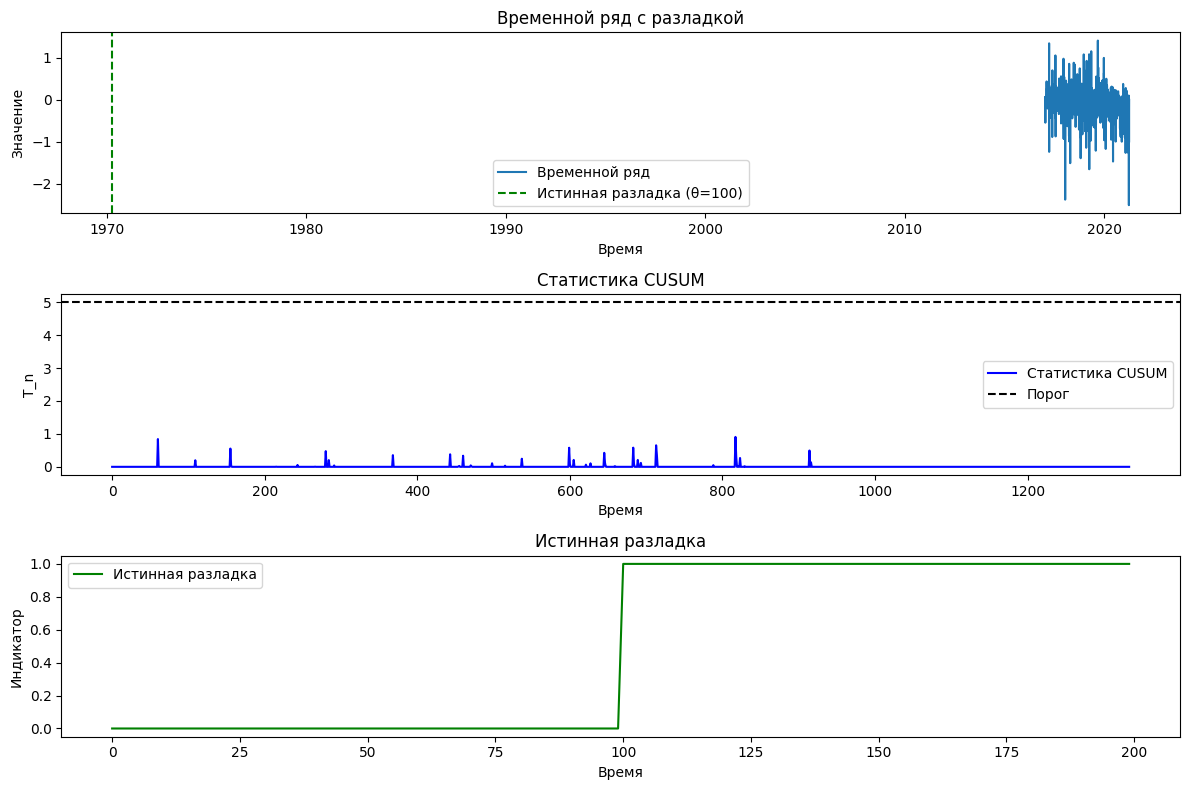

In [80]:
def cusum(data, mu_0=0, mu_1=1, sigma=1, threshold=5):
    """
    Обнаружение разладок с использованием метода CUSUM для нормального распределения.

    :param data: Временной ряд (список или numpy array)
    :param mu_0: Среднее до разладки (H∞)
    :param mu_1: Среднее после разладки (H0)
    :param sigma: Стандартное отклонение (предполагается известным и неизменным)
    :param threshold: Пороговое значение для обнаружения разладки
    :return: Индексы разладок и значения статистики CUSUM
    """
    data = np.array(data)
    T = np.zeros_like(data, dtype=float)  # Статистика CUSUM
    changepoints = []

    # Логарифм отношения правдоподобия для каждой точки
    for n in range(1, len(data)):
        zeta_n = ((mu_1 - mu_0) / (sigma ** 2)) * (data[n] - (mu_0 + mu_1) / 2)
        T[n] = max(0, T[n-1] + zeta_n)
        if T[n] >= threshold:
            changepoints.append(n)
            T[n] = 0  # Сброс после обнаружения разладки

    return changepoints, T

# # Генерация тестовых данных
np.random.seed(42)
n = 200
theta = 100
data_test = np.concatenate([np.random.normal(0, 1, theta), np.random.normal(1, 1, n - theta)])

# Применение CUSUM
changepoints, T_values = cusum(data['Balance'], mu_0=0, mu_1=1, sigma=1, threshold=5)

# Визуализация
plt.figure(figsize=(12, 8))

# График исходных данных
plt.subplot(3, 1, 1)
plt.plot(data['Balance'], label='Временной ряд')
plt.axvline(x=theta, color='g', linestyle='--', label=f'Истинная разладка (θ={theta})')
for cp in changepoints:
    plt.axvline(x=cp, color='r', linestyle='--', label='Обнаруженная разладка' if cp == changepoints[0] else None)
plt.title('Временной ряд с разладкой')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()

# График статистики CUSUM
plt.subplot(3, 1, 2)
plt.plot(T_values, label='Статистика CUSUM', color='b')
plt.axhline(y=5, color='k', linestyle='--', label='Порог')
for cp in changepoints:
    plt.axvline(x=cp, color='r', linestyle='--')
plt.title('Статистика CUSUM')
plt.xlabel('Время')
plt.ylabel('T_n')
plt.legend()

# График истинной разладки
plt.subplot(3, 1, 3)
true_changepoint = np.zeros(n)
true_changepoint[theta:] = 1
plt.plot(true_changepoint, label='Истинная разладка', color='g')
plt.title('Истинная разладка')
plt.xlabel('Время')
plt.ylabel('Индикатор')
plt.legend()
plt.tight_layout()

# Модуль отбора фичей

In [59]:
target = 'Balance'
features = [col for col in data.columns if col not in ['Date', target]]

X = data[features]
y = data[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

## встроенные методы отбора признаков
интегрируют отбор признаков в процесс обучения модели. Алгоритм машинного обучения сам оценивает важность признаков во время тренировки, используя свои внутренние механизмы (например, веса или коэффициенты)
- Учитывают взаимодействие между признаками, так как отбор происходит в контексте модели
- Если модель плохо подходит для данных, отбор признаков может быть неоптимальным

diff_2          0.382196
roll_max_3      0.209349
diff_1          0.167861
roll_min_3      0.063410
ratio_ma_3      0.039316
roll_mean_3     0.036178
roll_sum_3      0.032623
ratio_ma_7      0.017782
lag_2           0.013161
Outcome         0.011206
roll_std_3      0.004576
Income          0.003993
roll_std_7      0.002621
roll_max_7      0.001998
roll_min_7      0.001752
roll_std_14     0.001710
roll_min_14     0.001680
lag_1           0.001561
roll_mean_7     0.001420
cummean         0.001044
roll_sum_7      0.000988
lag_7           0.000688
roll_sum_14     0.000645
roll_max_14     0.000623
lag_3           0.000562
roll_mean_14    0.000519
cumsum          0.000511
ratio_lag_1     0.000027
dtype: float64

Выбранные признаки: ['diff_2', 'roll_max_3', 'diff_1', 'roll_min_3', 'ratio_ma_3', 'roll_mean_3', 'roll_sum_3', 'ratio_ma_7', 'lag_2', 'Outcome']


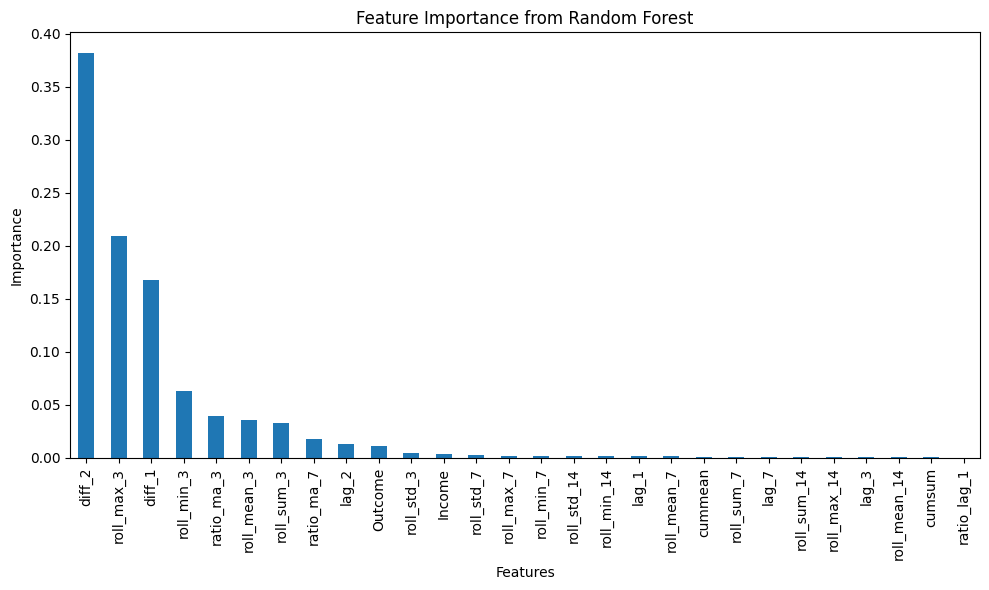

In [61]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_scaled, y)

feature_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
selected_features = feature_importance[feature_importance > 0.01].index.tolist()

print(feature_importance)
print("\nВыбранные признаки:", selected_features)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()

## оберточные методы отбора признаков

оценивают подмножества признаков, обучая модель на каждом подмножестве и измеряя ее производительность
- Учитывают взаимодействие признаков и оптимизируют производительность модели
- Высокая вычислительная сложность, особенно при большом числе признаков (комбинаторный взрыв)
- Риск переобучения, если валидационная выборка мала

In [62]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE

model = GradientBoostingRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_scaled, y)
selected_features = X_scaled.columns[rfe.support_].tolist()
print("Выбранные признаки:", selected_features)

Выбранные признаки: ['Income', 'lag_2', 'roll_mean_3', 'roll_min_3', 'roll_max_3', 'roll_sum_3', 'diff_1', 'diff_2', 'ratio_ma_3', 'ratio_ma_7']


## фильтрационные методы отбора признаков
оценивают важность признаков независимо от модели, используя статистические или корреляционные метрики
- Быстрые и вычислительно эффективные
- Игнорируют взаимодействие между признаками

In [63]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X_scaled, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=features).sort_values(ascending=False)
selected_features = mi_scores[mi_scores > 0.1].index.tolist()
print("Выбранные признаки:", selected_features)

Выбранные признаки: ['diff_2', 'roll_max_3', 'roll_min_3', 'diff_1', 'Outcome', 'roll_sum_3', 'roll_mean_3', 'ratio_ma_7', 'roll_std_3', 'ratio_ma_3', 'roll_max_7', 'Income', 'roll_min_7', 'ratio_lag_1', 'roll_max_14', 'roll_min_14', 'lag_7', 'roll_std_7', 'roll_sum_7', 'roll_mean_7', 'roll_sum_14', 'lag_2', 'roll_mean_14']


# Модуль оценки стабильности признаковой выборки

 можно применять на практике для оценки стабильности в трёх сценариях: - при отборе признаков с помощью <b>логистической L1-регуляризованной регрессии</b> на искусственном наборе данных, - при отборе признаков с помощью <b>elastic net</b>, - при отборе признаков на основе <b>взаимной информации (mutual information)</b> между признаками и целевой переменной. </ol>

In [ ]:
import stability as st

In [ ]:
import sklearn
from sklearn import metrics
import scipy.io as sio
import math

def getMutualInfos(data,labels):
    '''
    This function takes as input the data and labels and returns the mutual information of each feature 
    with the labels in a np.dnarray of length d
    
    INPUTS:
    - data is a 2-dimensional numpy.ndarray where rows are examples and columns are features
    - labels is a 1-dimansional numpy.ndarray giving the label of each example in data
    
    OUPUT:
    - a 1-dimensional numpy.ndarray of length d (where d is the number of features) 
      with the mutual information of each feature with the label
    '''
    M,d=data.shape
    mutualInfos=np.zeros(d)
    # for each feature
    for f in range(d):
        # we calculate the mutual information of the feature with the labels
        mutualInfos[f]=metrics.mutual_info_score(data[:,f],labels)
    return mutualInfos


def getBootstrapSample(data,labels):
    '''
    This function takes as input the data and labels and returns 
    a bootstrap sample of the data, as well as its out-of-bag (OOB) data
    
    INPUTS:
    - data is a 2-dimensional numpy.ndarray where rows are examples and columns are features
    - labels is a 1-dimansional numpy.ndarray giving the label of each example in data
    
    OUPUT:
    - a dictionnary where:
          - key 'bootData' gives a 2-dimensional numpy.ndarray which is a bootstrap sample of data
          - key 'bootLabels' is a 1-dimansional numpy.ndarray giving the label of each example in bootData
          - key 'OOBData' gives a 2-dimensional numpy.ndarray the OOB examples
          - key 'OOBLabels' is a 1-dimansional numpy.ndarray giving the label of each example in OOBData
    '''
    m,d=data.shape
    if m!= len(labels):
        raise ValueError('The data and labels should have a same number of rows.')
    ind=np.random.choice(range(m), size=m, replace=True)
    OOBind=np.setdiff1d(range(m),ind, assume_unique=True)
    bootData=data[ind,]
    bootLabels=labels[ind]
    OOBData=data[OOBind,]
    OOBLabels=labels[OOBind]
    return {'bootData':bootData,'bootLabels':bootLabels,'OOBData':OOBData,'OOBLabels':OOBLabels}

def generateAtificialDataset(m,d,d_rel,rho):
    ''' This function enerates the artificial dataset used in the experiments (Section 7.1) of [1].
        The data set is made of continuous data where the first
        d_rel featues are relevant and where the d-d_rel remaining features are irrelevant to the target class
        this is a balanced data set where m/2 examples belong to class -1 and m/2 to class 1
        
        INPUTS:
        m is the number of samples
        d is the number of features/variables
        d_rel is the number of relevant features
        rho is the degree of redundancy (should be between 0 and 1)
        
        OUPUTS:
        A dictionnary with the data and the labels
    '''
    if d_rel>=d:
        raise ValueError('The input number of relevant features d_rel must be strictly less than the total number of features d')
    if rho<0 or rho >1:
        raise ValueError('The input argument rho controlling the degree of redundancy between the relevant features must be a value between 0 and 1.');
    num_positives=int(m/2) ## Take half instances as positive examples
    num_negatives=m-num_positives
    labels=np.concatenate((np.ones((num_positives),dtype=np.int8),-np.ones((num_negatives),dtype=np.int8)))
    mu_plus=np.concatenate((np.ones((d_rel),dtype=np.int8),np.zeros((d-d_rel)))) ## mean of the positive examples
    mu_minus=np.concatenate((-np.ones((d_rel),dtype=np.int8),np.zeros(d-d_rel)))  ## mean of the negative examples
    Sigma_star=rho*np.ones((d_rel,d_rel),dtype=np.int8)+(1-rho)*np.eye(d_rel)
    sub1=np.concatenate((Sigma_star,np.zeros((d_rel,d-d_rel))))
    sub2=np.concatenate((np.zeros((d-d_rel,d_rel)),np.eye(d-d_rel)))
    Sigma=np.concatenate((sub1,sub2),axis=1) ## the covariance matrix
    positive_ex=np.random.multivariate_normal(mu_plus, Sigma,num_positives)
    negative_ex=np.random.multivariate_normal(mu_minus, Sigma,num_negatives)
    data=np.concatenate((positive_ex,negative_ex),axis=0)
    ## we randomly permute the examples...
    order=ind=np.random.choice(range(m), size=m, replace=False)
    data=data[order,]
    labels=labels[order]
    trueRelevantSet=np.zeros(d)
    trueRelevantSet[range(d_rel)]=1
    return {'data':data,'labels':labels,'trueRelevantSet':trueRelevantSet}


# Оптимизация стабильности и точности регуляризованных методов

Мы выбираем гиперпараметры, используемые для создания искусственного набора данных, как показано в [1].
Мы создаем набор данных с числом объектов d=100, в котором только первые объекты d<sub>rel</sub> относятся к целевому классу.
Мы выбрали среднюю степень избыточности rho=0,5.
Количество выборок bootstrap, выбранных для количественной оценки стабильности, равно M=100.

In [ ]:
## we pick the hyper-parameters to generate the aritifical dataset
m=1000 # number of samples
d=100 # number of features 
d_rel=50 # the first d_rel features are relevant
rho=0.5 # the degree of redundancy between the relevant features
M=100 # number of bootstrap samples
res=generateAtificialDataset(m,d,d_rel,rho)
data=res['data']
labels=res['labels']

Мы применяем L1-логистическую регрессию с различными регуляризующими параметрами lambda к M выборкам данных bootstrap с использованием пакета scikit-learn. Мы сообщаем о стабильности, как указано в [1], и повторяем среднюю ошибку "вне пакета" (OOB) для них.

In [ ]:
from sklearn import linear_model
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from scipy.stats import norm

## First, we pick the hyper-parameters 
alpha=0.05 # the level of significance for confidence intervals and hypothesis tests
num_lambdas=10
lambdas=np.linspace(-2,-1,num_lambdas)
lambdas=np.power(10,lambdas) ## this gives us lambda values between 10e-2 and 10e-1 (lambda is the regularising parameter)
Z=np.zeros((num_lambdas,M,d),dtype=np.int8)
errors=np.zeros((M,num_lambdas))
stabilities=np.zeros(num_lambdas)
errStab=np.zeros(num_lambdas)
numFeatSelected=np.zeros((M,num_lambdas),dtype=np.int32)
## for each repeat
for i in range(M):
    newData=getBootstrapSample(data,labels) ## we get a bootstrap sample
    for k in range(num_lambdas):
        logistic = LogisticRegression(penalty='l1',solver='liblinear',C=lambdas[k],max_iter=100) ## We use logostic LASSO
        logistic.fit(newData['bootData'],newData['bootLabels'])  ## we fit the coefficients 
        Z[k,i,:]=sum(logistic.coef_!=0)
        numFeatSelected[i,k]=sum(sum(logistic.coef_!=0))
        predLabels=logistic.predict(newData['OOBData'])
        errors[i,k]=1-metrics.accuracy_score(newData['OOBLabels'], predLabels)
meanError=np.mean(errors,0)
errCI=norm.ppf(1-alpha/2)*(np.std(errors,0))/math.sqrt(M)

for k in range(num_lambdas):
    res=st.confidenceIntervals(Z[k,:,:],alpha=alpha) ## we get the confidence intervals using the stability package
    stabilities[k]=res['stability']
    errStab[k]=stabilities[k]-res['lower']
    

Давайте сначала построим график количества выбранных объектов по мере увеличения регуляризующего параметра lambda.

In [ ]:
plt.close()
plt.figure()
plt.plot(lambdas,np.mean(numFeatSelected,0),marker='o', linestyle='--')
plt.xlabel('lambda')
plt.ylabel('num. Features selected')
plt.title('Number of Features selected against Lambda')
plt.show()

Как мы и ожидали, количество выбранных функций уменьшается по мере того, как мы увеличиваем регуляризацию. <br>
Давайте теперь построим график средней ошибки OOB в зависимости от лямбда-выражения.

In [ ]:
plt.close()
plt.figure()
plt.plot(lambdas,np.mean(errors,0),marker='o', linestyle='--')
plt.xlabel('lambda')
plt.ylabel('Av. error')
plt.title('Average OOB Error')
plt.show()

Давайте построим график зависимости стабильности от лямбда-выражения, используя 95% доверительные интервалы (используя пакет стабильности).

In [ ]:
plt.close()
plt.figure()
plt.errorbar(1/lambdas,stabilities,yerr=errStab,marker='o', linestyle='--')
plt.xlabel('lambda')
plt.ylabel('Stability')
plt.title('Stability against Lambda')
plt.show()

Мы можем построить график зависимости стабильности от ошибки OOB.

In [ ]:
plt.close()
plt.figure()
plt.errorbar(meanError,stabilities,yerr=errStab,marker='o', linestyle='--')
plt.xlabel('Error')
plt.ylabel('Stability')
plt.title('Stability against Av. OOB Error')
plt.show()

ВЫВОД:<br>
Как мы можем видеть из этих рисунков, значение регуляризующего параметра, которое обеспечивает максимальную стабильность (из 10 выбранных регуляризирующих параметров), не является значением, дающим минимальную погрешность. Здесь необходимо найти компромисс между погрешностью и стабильностью.Тем не менее, мы видим, что небольшая жертва с точки зрения точности может в значительной степени улучшить стабильность.

<b> ИСПОЛЬЗОВАНИЕ ЭЛАСТИЧНОЙ СЕТКИ </b> <br>
В этом разделе мы воспроизводим эксперименты на том же наборе данных с использованием эластичной сетки.

In [ ]:
## we use the ElasticNet package from scikit-learn
from sklearn.linear_model import ElasticNet

M=30 ## for computational reasons, we reduce M to 30 here. 
## This will give us larger confidence intervals and more variance in the stability estimates
## Nevertheless, we have shown in the paper [1] that M=30 suffices in most scenarios
num_ratios=10
num_alphas=10
alphas=np.linspace(0.05,0.95,num_alphas) ## the first hyper-parameter of the elastic net
ratios=np.linspace(0.01,0.8,num_ratios)  ## the second hyper-parameter of the elastic net
Z_net=np.zeros((num_ratios,num_alphas,M,d),dtype=np.int8)
errors_net=np.zeros((M,num_ratios,num_alphas))
stabilities_net=np.zeros((num_ratios,num_alphas))
errStab_net=np.zeros((num_ratios,num_alphas))
numFeatSelected_net=np.zeros((M,num_ratios,num_alphas),dtype=np.int32)
for i in range(M):
    newData=getBootstrapSample(data,labels) ## we get bootstrap samples
    for k in range(num_ratios):
        for l in range(num_alphas):
            net=ElasticNet(alpha=alphas[l],l1_ratio=ratios[k],max_iter=500) ## we use elastic net
            net.fit(newData['bootData'],newData['bootLabels'])
            Z_net[k,l,i,net.coef_!=0]=1
            numFeatSelected_net[i,k,l]=np.sum(Z_net[k,l,i,],axis=0)
            predLabels_net=np.zeros(len(newData['OOBData']))
            temp=net.predict(newData['OOBData'])
            for j in range(len(newData['OOBData'])):
                if temp[j]>=0: predLabels_net[j]=1
                else:  predLabels_net[j]=-1
            errors_net[i,k,l]=1-metrics.accuracy_score(newData['OOBLabels'], predLabels_net)
meanError_net=np.mean(errors_net,0)

for k in range(num_ratios):
    for l in range(num_alphas):
        ## we use the stability package to get the stability estimate and its confidence intervals
        res=st.confidenceIntervals(Z_net[k,l,],alpha=alpha)    
        stabilities_net[k,l]=res['stability']
        errStab_net[k,l]=stabilities_net[k,l]-res['lower']
    

На графике выше каждая линия представляет различные параметры соотношения эластичной сетки. <br>
Поскольку эти эксперименты служат лишь иллюстративной цели, мы не возражали против сходимости алгоритма оптимизации эластичной сети и сохранили максимальное число итераций равным 500. <br><br>

На всех рисунках ниже каждая линия соответствует определенному гиперпараметру ratio, а каждая точка линии соответствует другому значению альфа (второму гиперпараметру сети ealstic).

In [ ]:
import matplotlib.pyplot as plt
plt.close()
plt.figure()
numFeatSelected_net[i,k,l]
for k in range(num_ratios):
    plt.plot(alphas,np.mean(numFeatSelected_net[:,k,:],axis=0))
plt.xlabel('alphas')
plt.ylabel('num. Features selected against alpha for different L1-ratios')
plt.title('Number of Features selected against the L1-Ratio in Elastic Net')
plt.show()

In [ ]:
plt.close()
plt.figure()
for k in range(num_ratios):
    plt.errorbar(alphas,stabilities_net[k,:],yerr=errStab_net[k,:])
plt.xlabel('alpha')
plt.ylabel('Stability')
plt.title('Stability against alpha for different L1-ratios')
plt.show()

In [ ]:
plt.close()
plt.figure()
for k in range(num_ratios):
    plt.errorbar(meanError_net[k,:],stabilities_net[k,:],yerr=errStab_net[k,:])
plt.xlabel('Error')
plt.ylabel('Stability')
plt.title('Stability against Av. OOB Error')
plt.show()

ВЫВОДЫ:<br>
Как мы видим, гиперпараметры, оптимизирующие погрешность нашей модели, отличаются от тех, которые оптимизируют стабильность. <br>
Тем не менее, мы видим, что в этом случае можно выбрать разумный компромисс между ними, с высокой стабильностью и низкой ошибкой.

### Пример из теории информации

Давайте предположим, что теперь мы выбираем топ-k объектов, которые обладают наибольшей взаимной информацией с целевым классом. <br>
Мы проверяем стабильность этой процедуры выбора признака в сравнении с k в примере ниже. <br>
Для этой цели мы используем набор данных heart из репозитория UCI, где мы дискретизировали объекты, используя 10 ячеек, как это сделано в [3] (набор данных доступен по адресу [4]).

In [ ]:
## We set the chosen hyper-parameters
M=100
dataName='heartEW.mat'
kValues=range(1,d-1) ## an array with the number of features we want to select
## We load the desired dataset
res=sio.loadmat(dataName)
data=res['data']
labels=res['labels']
m,d=data.shape
labels=labels.reshape(m)
Z=np.zeros((len(kValues),M,d),dtype=np.int8) # this will store the M feature sets
for i in range(M):
    newData=getBootstrapSample(data,labels) ## we get bootstrap samples
    mutualInfos=getMutualInfos(newData['bootData'],newData['bootLabels']) ## we get the mutual informaion on the bootstrap samples
    ind=np.argsort(mutualInfos) #sorts the mutual informations in increasing order
    for j in range(len(kValues)):
        ## we retrieve the indices of the top-k mutual informations
        #print(list(range(d-1,d-1-kValues[j],-1)))
        topK=ind[range(d-1,d-1-kValues[j],-1)] ## the indices of the features with the kValues[k] highest MIs 
        Z[j,i,topK]=1 
# now we get the stability with confidence intervals   
stabilities=np.zeros(len(kValues))
stabErr=np.zeros(len(kValues))
for j in range(len(kValues)):
    res=st.confidenceIntervals(Z[j,],alpha=0.05)
    stabilities[j]=res['stability']
    stabErr[j]=stabilities[j]-res['lower']

In [ ]:
import matplotlib.pyplot as plt
stabilities=np.zeros(len(kValues))
stabErr=np.zeros(len(kValues))
for j in range(len(kValues)):
    res=st.confidenceIntervals(Z[j,],alpha=0.05)
    stabilities[j]=res['stability']
    stabErr[j]=stabilities[j]-res['lower']
plt.close()
plt.figure()
plt.errorbar(kValues,stabilities,yerr=stabErr,marker='o', linestyle='--')
plt.ylabel('stability')
plt.xlabel('Number of features selected k')
plt.title("Stability of the selection of the top-k feature against k on the "+dataName+" dataset")
plt.show()

<b>ВЫВОДЫ:</b><br>
- На рисунке выше мы можем наблюдать, как стабильность меняется в зависимости от количества выбранных признаков k в наборе данных о сердце. Мы также предоставляем 95%-ные доверительные интервалы, указывающие на то, что в 95% случаев истинная стабильность популяции будет соответствовать этому интервалу. 
- На практике это не может быть использовано в одиночку для выбора количества объектов, которые будут выбраны. Гиперпараметры алгоритма (в данном случае количество выбранных объектов k) должны быть оптимизированы с учетом стабильности и ошибки обобщения многоцелевым способом. Часто приходится искать компромисс между стабильностью и ошибкой классификации.

# Построение модели

# GARCH (Generalized ARCH)

GARCH(p,q):


$$ h_n = \sigma_n \varepsilon_n,$$

$$\sigma_n^2 = a_0+ \sum_{i=1}^q a_i h_{n-i}^2 + \sum_{j=1}^{p} b_{j} \sigma_{n-j}^2.$$
    
   Основное преимущество GARCH(𝑝, 𝑞)-моделей перед ARCH(𝑝)-моделью, состоит в подборе параметров модели. На практике периодически может оказаться так, что при подгонке статистических данных моделями ARCH(𝑝) параметр 𝑝 становится слишком большим (что усложняет анализ модели), в то время как при подгонке GARCH(𝑝, 𝑞)-моделями можно ограничиваться небольшими значениями 𝑝 и 𝑞.

GARCH – это ARMA-процесс для дисперсии серии.

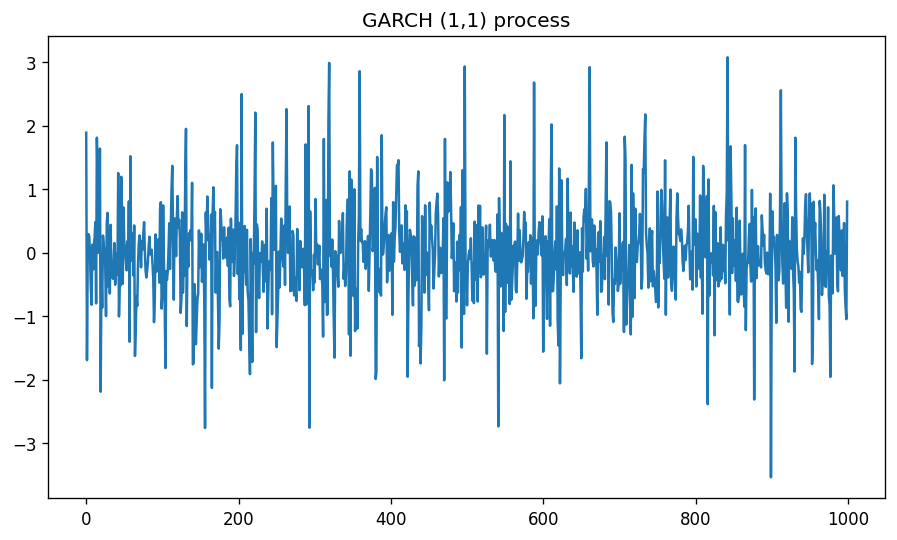

In [80]:
import scipy as sp

n=1000 # n is the number of observations
n1=100 # we need to drop the first several observations
n2=n+n1 # sum of two numbers
alpha=(0.1,0.3) # GARCH (1,1) coefficients alpha0 and alpha1, see
a=(0.1,0.3) # ARCH (1) coefficients alpha0 and alpha1, see Equation

beta=0.2
errors=np.random.normal(0,1,n2)
t=np.zeros(n2)
t[0]=np.random.normal(0,np.sqrt(a[0]/(1-a[1])),1)
for i in range(1,n2-1):
    t[i]=errors[i]*np.sqrt(alpha[0]+alpha[1]*errors[i-1]**2+beta*t[i-1]**2)
y=t[n1-1:-1] # drop the first n1 observations
plt.title('GARCH (1,1) process')
x=range(n)
plt.plot(x,y)

In [82]:
from arch import arch_model

am = arch_model(df['Balance'])
res = am.fit()

print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 894837980.6155534
Iteration:      2,   Func. Count:     12,   Neg. LLF: 114563.30053335318
Iteration:      3,   Func. Count:     18,   Neg. LLF: 291891.0918811089
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5336.992035289009
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5642.670192838197
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4760.342078666608
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4804.00166571843
Iteration:      8,   Func. Count:     47,   Neg. LLF: 5670.510981919861
Iteration:      9,   Func. Count:     54,   Neg. LLF: 4745.970020244292
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4738.932962988565
Iteration:     11,   Func. Count:     64,   Neg. LLF: 4736.328296517595
Iteration:     12,   Func. Count:     69,   Neg. LLF: 4735.940085868222
Iteration:     13,   Func. Count:     74,   Neg. LLF: 4735.906245954549
Iteration:     14,   Func. Count:     79,   Neg. LLF: 4735.90601

Обычно коэффициент  GARCH модели   β1  близок к 0.9 для многих ежедневных финансовых данных.

Можно показать, что чем   α1+β1 ближе к 1, тем дольше мы ощущаем эффекты "шоков" в волатильности.

Если в модели a1 + b1 > 1, GARCH прогноз будет нестационарным и волатильность со временем возрастет до бесконечности.

In [83]:
res.params

mu         -0.088044
omega       6.428910
alpha[1]    0.932878
beta[1]     0.067122
Name: params, dtype: float64

# Оценка модели на адекватность
Если GARCH оценена адекватно, то остатки не должны содержать автокорреляцию или любой другой тип нелинейной зависимости.

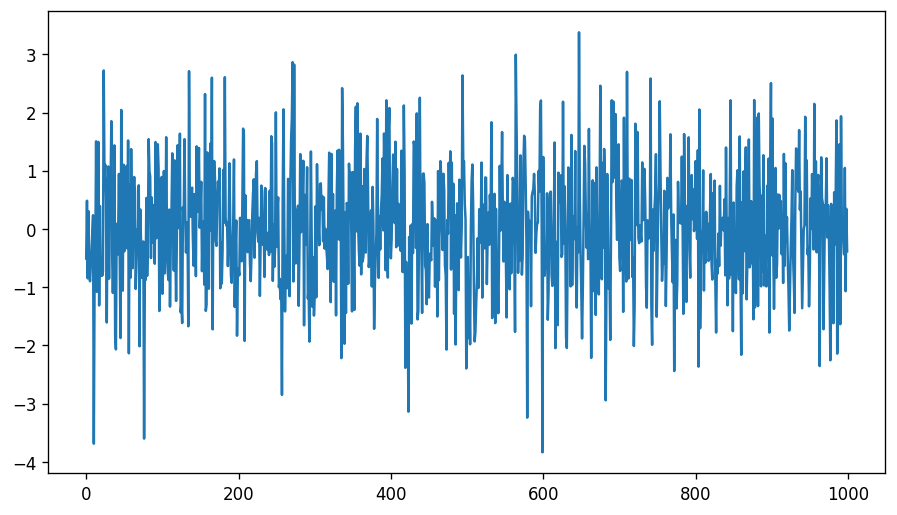

In [84]:
normal = pd.Series(np.random.normal(0, 1, size=1000))
normal.plot();

Оценим параметры на 7 года, построим прогноз на 1 год вперед.

In [85]:
df['Balance']

Date
2017-01-15   -15.589604
2017-01-16    12.286109
2017-01-17    -5.986892
2017-01-18     4.954974
2017-01-19    -8.664010
                ...    
2021-03-27    20.133646
2021-03-28   -30.542899
2021-03-29    39.857611
2021-03-30   -27.245827
2021-03-31     0.507560
Freq: D, Name: Balance, Length: 1537, dtype: float64

In [90]:
split_date = pd.to_datetime('2021-03-01') 
am = arch_model(df['Balance'])
res = am.fit(last_obs=split_date, disp='off')

# res - результат фита модели на первых 7  годаъ

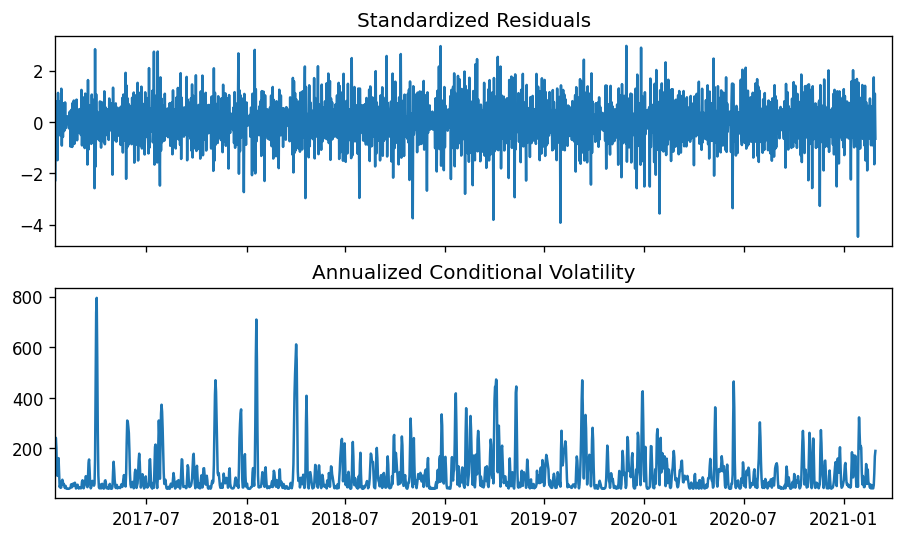

In [91]:
fig = res.plot(annualize='D')

# остатки после фита модели:

После вызова forecast()  возвращается ARCHModelForecast объект с атрибутами:

mean - The forecast conditional mean.

variance - The forecast conditional variance.

residual_variance - The forecast conditional variance of residuals. 

In [92]:
# строим прогноз на 30 горизонтов от даты split_date
forecasts = res.forecast(horizon=30, start=split_date) 
forecasts.variance.tail()

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-27,415.194171,421.324474,427.454776,433.585079,439.715382,445.845685,451.975987,458.106290,464.236593,470.366896,...,537.800226,543.930529,550.060832,556.191134,562.321437,568.451740,574.582043,580.712345,586.842648,592.972951
2021-03-28,897.158946,903.289249,909.419552,915.549855,921.680157,927.810460,933.940763,940.071066,946.201369,952.331671,...,1019.765002,1025.895304,1032.025607,1038.155910,1044.286213,1050.416515,1056.546818,1062.677121,1068.807424,1074.937726
2021-03-29,1552.305647,1558.435950,1564.566252,1570.696555,1576.826858,1582.957161,1589.087463,1595.217766,1601.348069,1607.478372,...,1674.911702,1681.042005,1687.172308,1693.302610,1699.432913,1705.563216,1711.693519,1717.823821,1723.954124,1730.084427
2021-03-30,801.449638,807.579941,813.710244,819.840547,825.970850,832.101152,838.231455,844.361758,850.492061,856.622363,...,924.055694,930.185996,936.316299,942.446602,948.576905,954.707208,960.837510,966.967813,973.098116,979.228419
2021-03-31,63.371957,69.502260,75.632563,81.762866,87.893169,94.023471,100.153774,106.284077,112.414380,118.544682,...,185.978013,192.108315,198.238618,204.368921,210.499224,216.629527,222.759829,228.890132,235.020435,241.150738


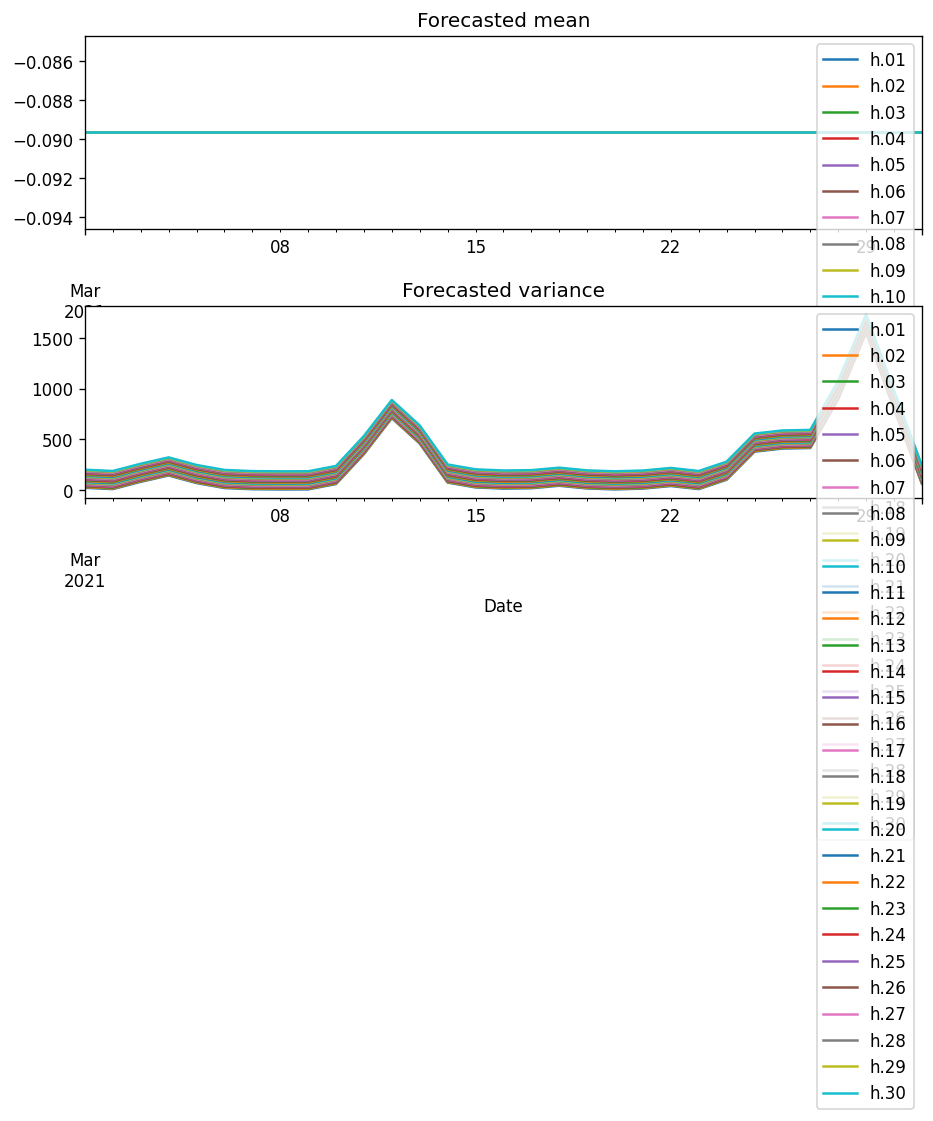

In [93]:
# среднее прогноза 
forecasts.mean[split_date:].plot(ax=plt.subplot(2, 1, 1));
plt.title('Forecasted mean')

# дисперсия прогноза 
forecasts.variance[split_date:].plot(ax=plt.subplot(2, 1, 2));
plt.title('Forecasted variance')
plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.show()

# Выбор модели

Так как GARCH модель может быть рассмотрена как  ARMA для квадратов отклонений, можно использовать информационный критерий  (AIC) или (BIC).

Если для ежедневных доходностей мы ограничемся только ARCH(p) модель, то мы можем подобрать очень большое значение p по информационному критерию. 

Для  GARCH(p,q) обычно подбираем p,q ≤ 2 по информационным критериям. Модель GARCH(p,q) с меньшим параметрами предпочтительна перед ARCH(p) с  большим параметром p (устойчивость оценок и переобучение).

# Приложение к финансам 

Рассмотрим индекс SP500:

Прогоним ARIMA(p, d, q) для наших данных и убедимся в автокорреляции остатков.

Выберем GARCH к ARIMA с наименьшим AIC.

Посмотрим на остатки модели

In [94]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

In [95]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
      
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [96]:

def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl



In [97]:
TS = df
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)
res_tup = _get_best_model(TS)

aic:    inf | order: None


In [ ]:
order = res_tup[1]
model = res_tup[2]

tsplot(model.resid, lags=30)

In [ ]:
# Фит модели

p_ = order[0]
o_ = order[1]
q_ = order[2]


am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

In [ ]:
#Посмотрим на остатки

tsplot(res.resid, lags=30)

In [ ]:
# Выглядит, как белый шум. Посмотрим на квадраты

tsplot(res.resid**2, lags=30)


 # Анализ остатков

Анализ остатков — это техника, которая помогает понять, есть ли у прогнозирующей модели небольшие
недостатки, которые можно устранить доработкой, или же фундаментальные проблемы.

Остатки — это разность между фактом и прогнозом:
$$\hat ε_t = y_t − \hat y_t.$$

Их можно вычислять двумя способами. 

1. Прогнозы, которые участвуют в остатках, можно строить
с фиксированной отсрочкой. Например, начиная с момента R прогноз всегда делается на одну точку вперёд,
затем происходит переход в момент R + 1, получается новое истинное значение ряда, которое сравнивается с
прогнозом, затем следующий прогноз делается ещё на одну точку вперёд, и так далее до самого конца ряда:
$$\hat y_{R+d|R}, \dots , \hat y_{T|T −d}.$$


2. Остатки можно строить с фиксированным концом истории при разных отсрочках. Например,
берётся начальная часть ряда от 0 до T − D, и далее делаются прогнозы


$$ \hat y_{T −D+1|T −D},\dots , \hat y_{T|T −D},$$
полученные прогнозы сравниваются с истинными значениями ряда, и с их помощью вычисляются остатки.


В зависимости от задачи могут использоваться разные определения остатков, однако чаще используется
первое. Остатки оценивают ошибку, то есть шумовую компоненту, которую наблюдать невозможно. При
построении модели делаются предположения об этой шумовой компоненте, и логично, что свойства остатков
должны согласовываться с выдвинутыми предположениями.


# Несмещённость
Во-первых, остатки должны быть несмещёнными, то есть в среднем они должны быть равны нулю.

Гипотезу о несмещённости остатков $H_0 : ε = 0$ можно формально проверить с помощью какого-либо стандартного одновыборочного критерия (например, критерия Стьюдента или Уилкоксона). Если выясняется,
что остатки смещены, значит с моделью что-то не так. В этом случае рекомендуется провести визуальный
анализ, чтобы посмотреть, почему прогнозы систематически завышаются или занижаются.


На самом деле, модель очень легко скорректировать в случае, если остатки имеют смещение. Достаточно
вычислить среднее значение остатков, это и будет константой, на которую необходимо скорректировать все
прогнозы, чтобы остатки стали несмещёнными. После этого преобразования прогнозирующая модель улучшится.

# Стационарность

Ещё одно свойство, наличие которого предполагается у ошибок, — это стационарность, то есть отсутствие
зависимости от времени. Таким образом, остатки во времени должны быть распределены примерно одинаково.

Формально гипотезу о стационарности можно проверить с помощью критерия Дики-Фуллера. Если стационарность отсутствует, то модель неодинаково точна в разные периоды времени. Необходимо провести
визуальный анализ, чтобы понять, что с моделью не так, и почему прогнозы в разные периоды времени
систематически имеют разную ошибку.

 # Неавтокоррелированность


Ещё одно желаемое свойство остатков — это неавтокоррелированность, то есть отсутствие зависимости от
предыдущих наблюдений.


Гипотезу о неавтокоррелированности можно проверить по коррелограмме, а также с помощью Q-критерия Льюнга-Бокса (таблица 1.3). Этот критерий позволяет проверить гипотезу о равенстве нулю одновременно
нескольких автокорреляций при разных лагах (с лага 1 по лаг Q). Параметр Q можно выбирать, например,
перебором, а можно пользоваться значением по умолчанию, использующемся в функции, которая производит
оценку модели ARIMA.

ряд ошибок прогноза: $ε^T = ε_1, \dots, ε_T$
нулевая гипотеза: $H_0 : r_1 = · · · = r_Q = 0$
альтернатива: $H_1 : H_0 $ неверна
статистика: $Q(ε^T)= T (T + 2)\sum_{\tau=1}^Q \frac{r^2_τ}{T −τ}$
нулевое распределение: $Q(ε^T) ∼ χ^2_{Q−K}$ при $H_0$, 
K — число настраиваемых параметров модели.




Автокоррелированность остатков — признак того, что в данных присутствует информация, которая не
вошла в модель. 

Если в остатках есть структура, то можно попытаться её внести в модель явным образом.


Скорректированная модель будет лучше, а её остатки будут больше похожи на белый шум. 

Таким образом, автокоррелированность остатков только указывает на
потенциальную возможность улучшить модель, и не факт, что улучшения можно добиться на практике с
помощью рассматриваемого класса моделей.